In [2]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

In [3]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [4]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

# What affects the number of daily flights?

In [4]:
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

In [5]:
# make dates from year, month, day
flights["date"] = pd.to_datetime(flights[["year", "month", "day"]])

In [6]:
daily = flights.groupby("date").size().reset_index(name="n")
daily

          date    n
0   2013-01-01  842
1   2013-01-02  943
2   2013-01-03  914
..         ...  ...
362 2013-12-29  888
363 2013-12-30  968
364 2013-12-31  776

[365 rows x 2 columns]

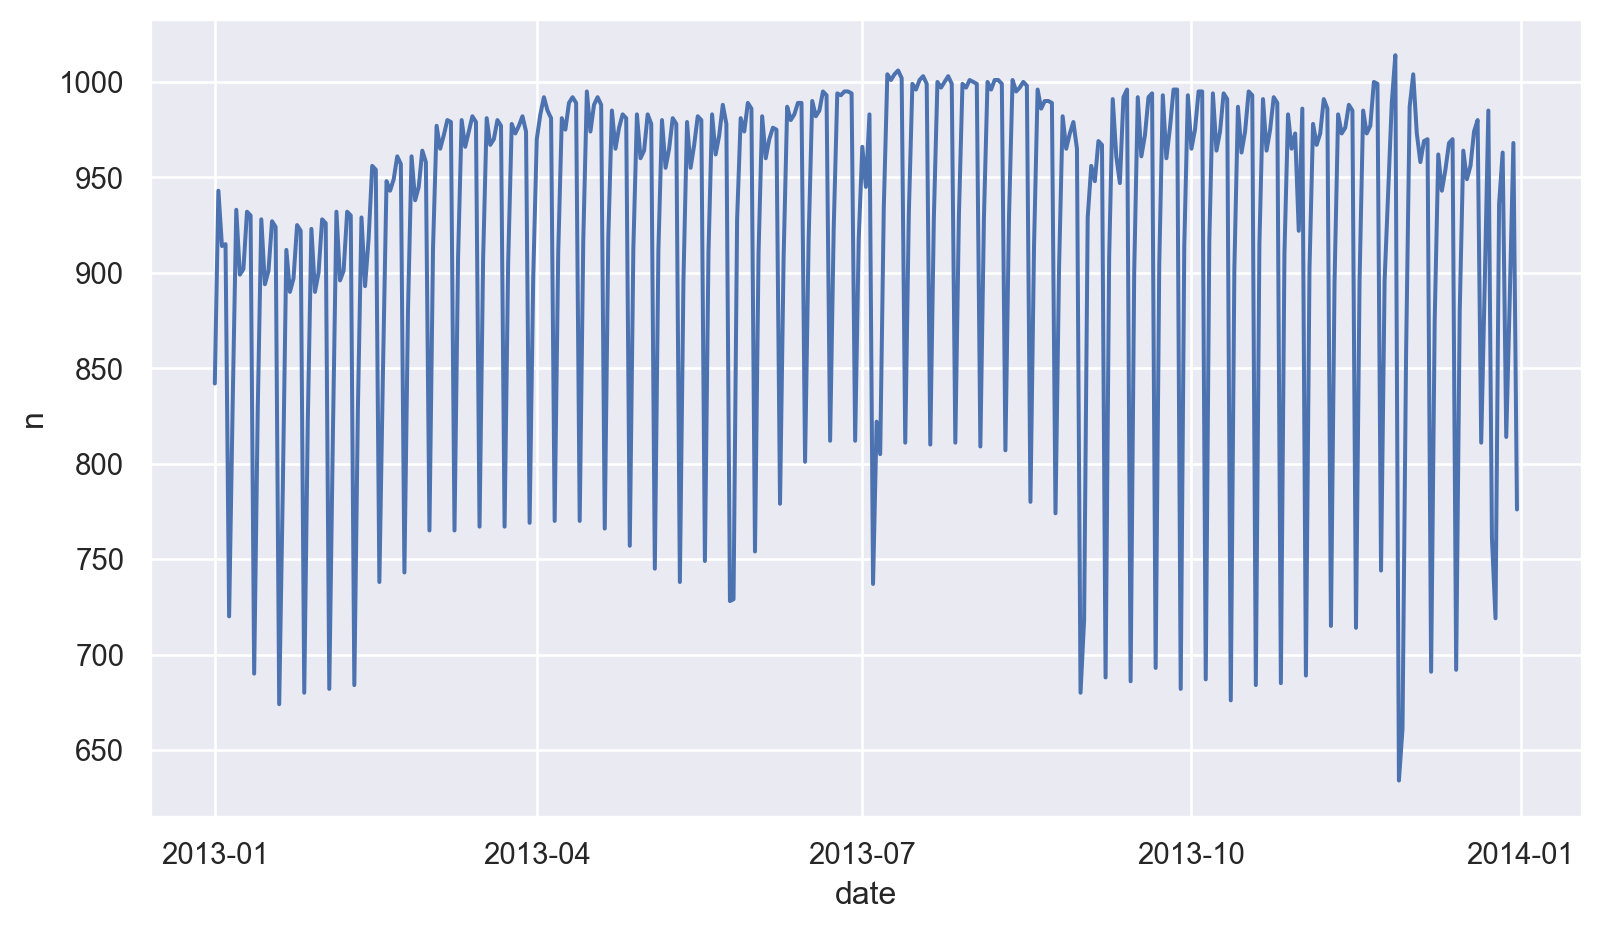

In [7]:
(
    so.Plot(daily, x='date', y='n')
    .add(so.Line())
    .layout(size=(8.5, 5))
)

## 1. Day of week (요일)

항공편의 개수는 요일에 따른 효과가 크게 미치기 때문에 우선 요일의 효과를 살펴보면서 장기간의 트렌드를 이해하고자 함

In [8]:
# add a column for the day of the week
daily["wday"] = (
    daily["date"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

In [9]:
daily

          date    n wday
0   2013-01-01  842  Tue
1   2013-01-02  943  Wed
2   2013-01-03  914  Thu
..         ...  ...  ...
362 2013-12-29  888  Sun
363 2013-12-30  968  Mon
364 2013-12-31  776  Tue

[365 rows x 3 columns]

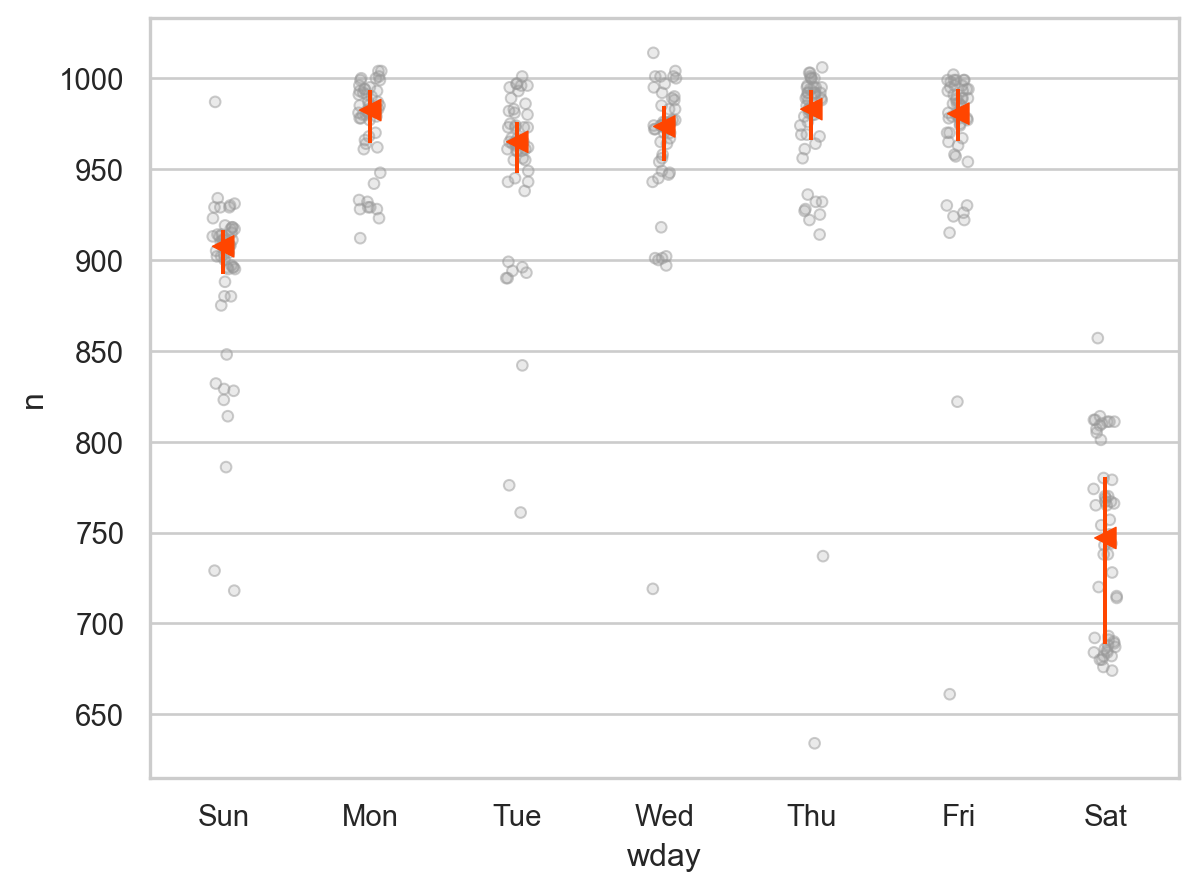

In [10]:
import sbcustom
sbcustom.boxplot(daily, "wday", "n", alpha=.5)

매우 강한 주말 효과를 제거하기 위해 모델을 만들어 residuals을 얻음

In [11]:
from statsmodels.formula.api import ols 
# 또는 import statsmodels.formula.api as smf

mod = ols("n ~ wday", data=daily).fit()

In [12]:
pd.options.display.max_rows = 7

In [13]:
# create a grid from wday with categorical dtype
grid = pd.DataFrame({"wday": ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]})

In [14]:
grid["pred"] = mod.predict(grid["wday"])
grid

  wday   pred
0  Sun 891.48
1  Mon 974.81
2  Tue 951.36
3  Wed 962.69
4  Thu 965.75
5  Fri 967.46
6  Sat 744.62

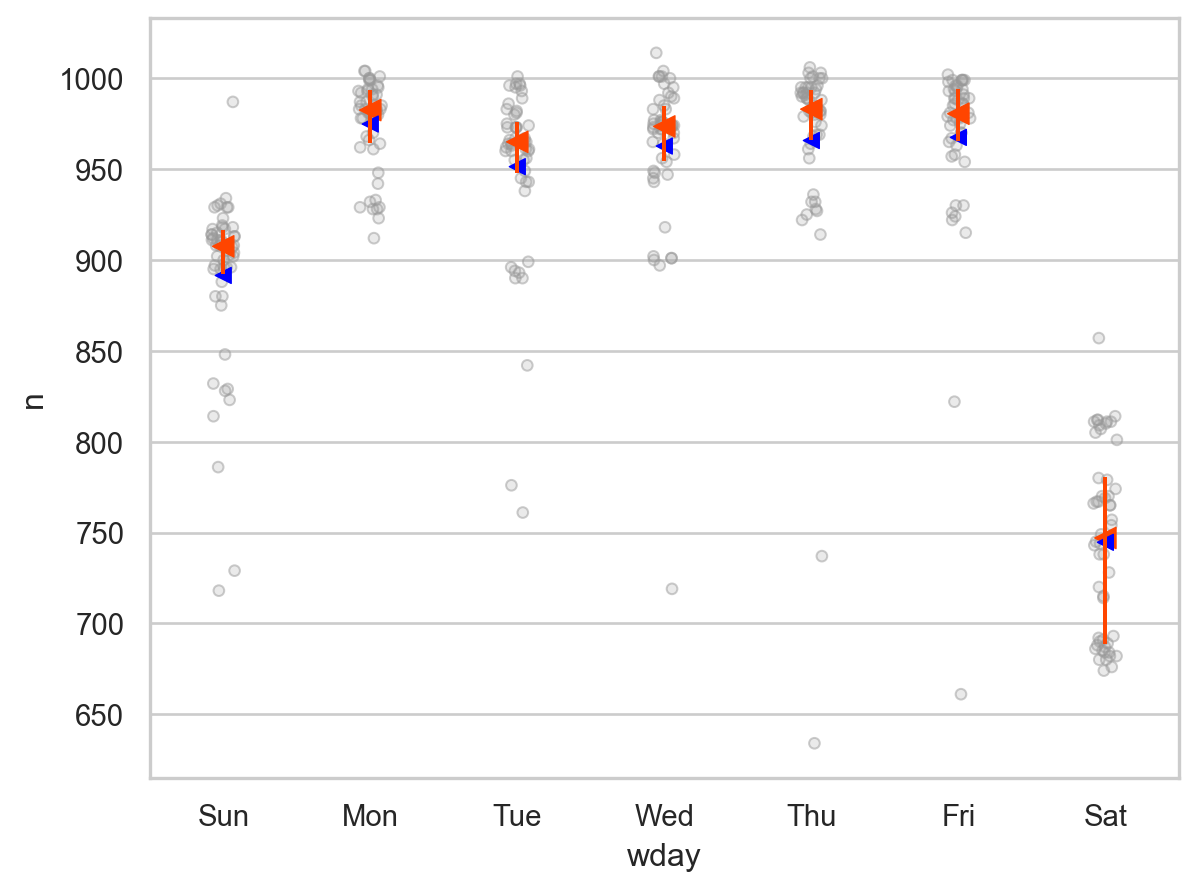

In [15]:
(
    sbcustom
    .boxplot(daily, "wday", "n", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.wday, y=grid.pred)
    .scale(x=so.Nominal(order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]))
)

Residuals: 요일의 효과를 제거한 후의 날짜와 항공편의 개수의 관계

In [16]:
# add a column of residuals from mod
daily["resid"] = mod.resid

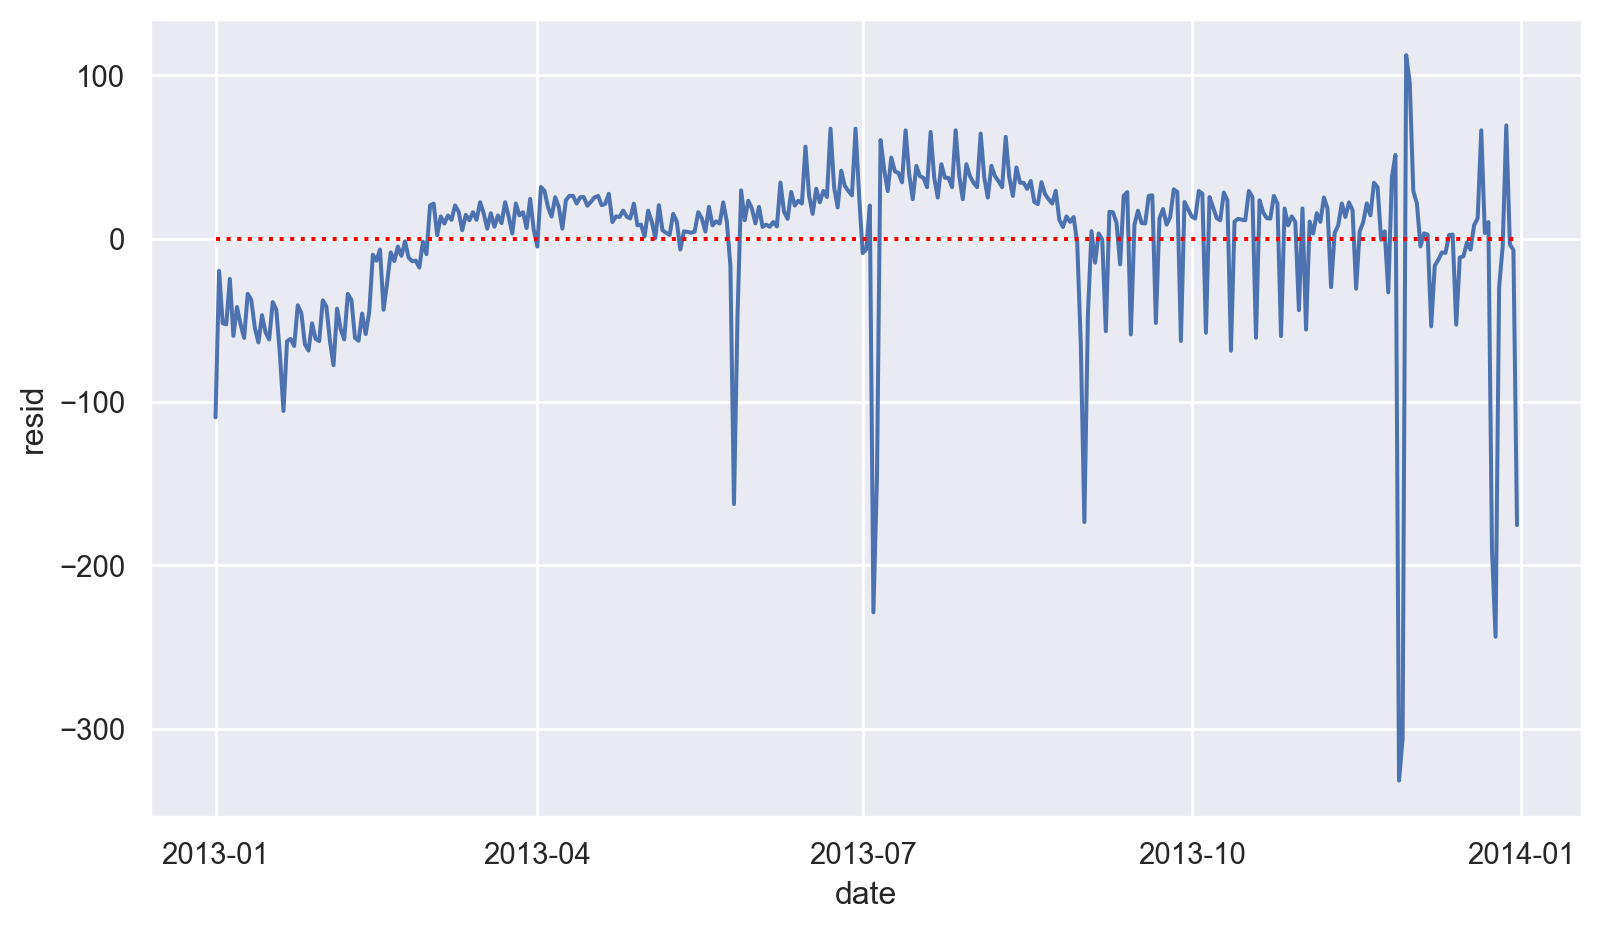

In [17]:
ref_line = pd.DataFrame({"x": ["2013-01-01", "2013-12-31"], "y": [0, 0]})
ref_line["x"] = pd.to_datetime(ref_line["x"])

(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), x=ref_line.x, y=ref_line.y)
    .layout(size=(8.5, 5))
)

### 살펴볼 것들
1. 6월부터 모델이 잡아내지 못한 패턴들이 심해짐. 이를 위해 우선, 요일별로 잔차를 들여다 보면,

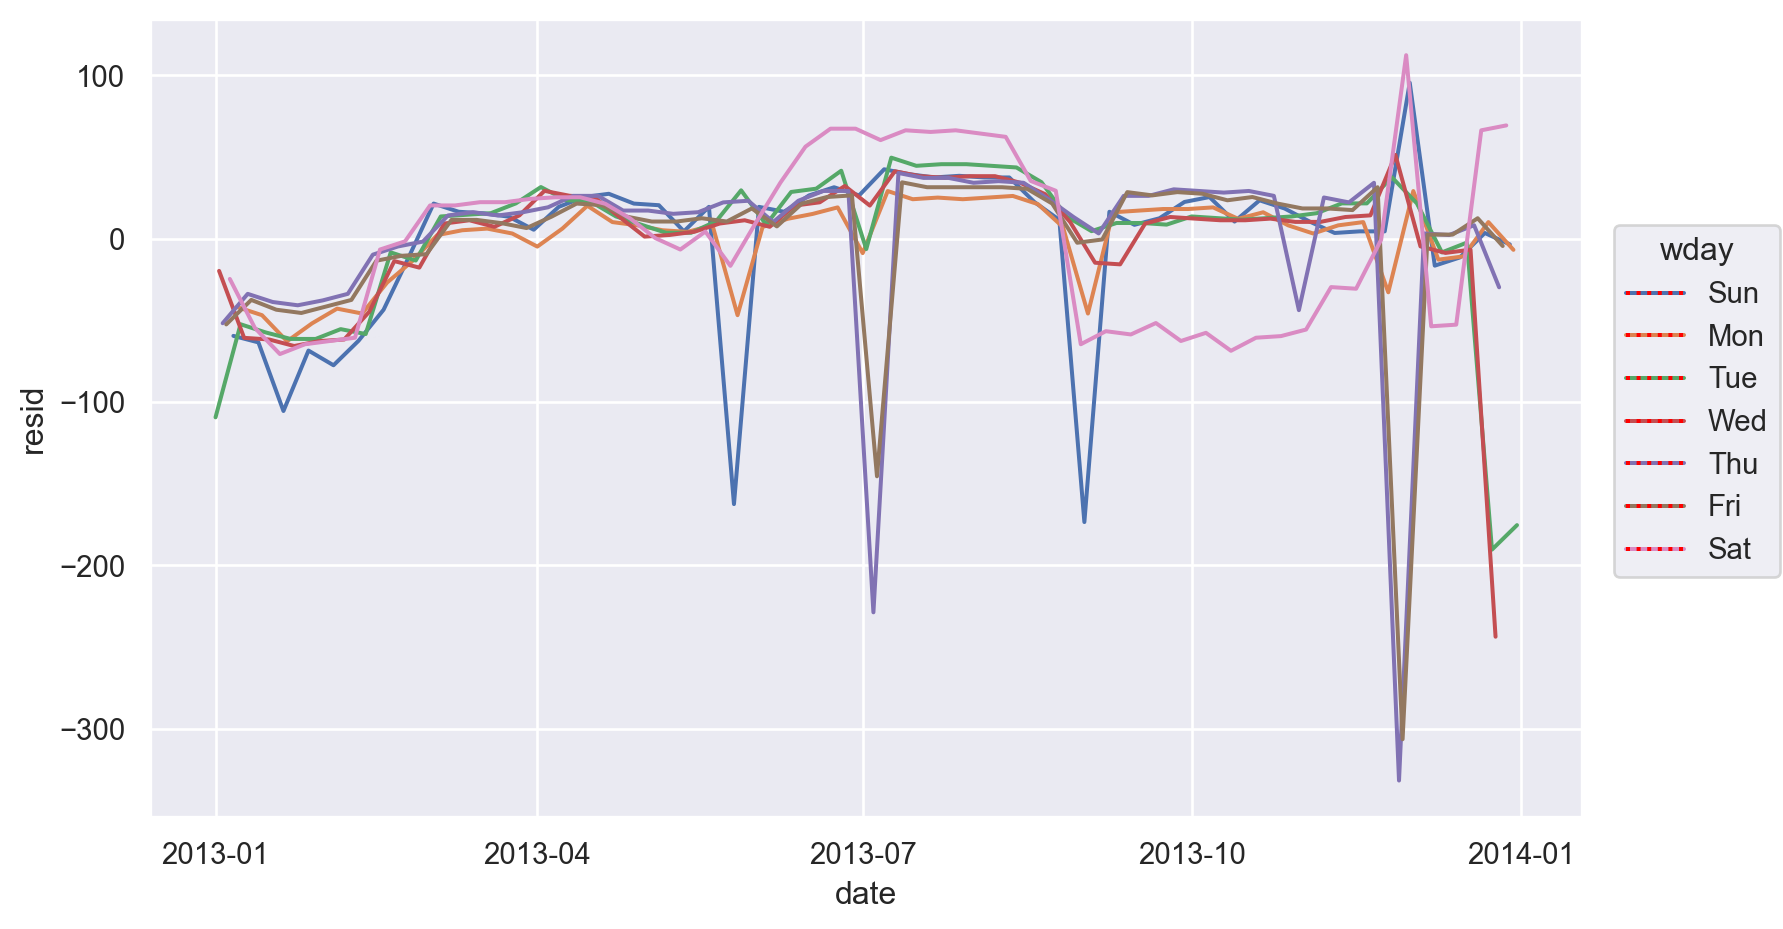

In [18]:
(
    so.Plot(daily, x='date', y='resid', color="wday")
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), x=ref_line.x, y=ref_line.y)
    .layout(size=(8.5, 5))
)

토요일의 패턴을 잡아내지 못했음:  
토요일 여름에 모델의 기대치보다(즉, 토요일 1년 평균보다) 더 많은 항공편이 있고, 가을에는 반대로 더 적은 항공편이 있음. 뒤에 이를 고려한 새로운 모델을 세워 봄

2. 특히나 적은 항공편이 있는 날들이 있어서 그 날들을 살펴보면

In [19]:
#| echo: false
pd.options.display.max_rows = 0

In [20]:
daily.query('resid < -100')

          date    n wday   resid
0   2013-01-01  842  Tue -109.36
19  2013-01-20  786  Sun -105.48
145 2013-05-26  729  Sun -162.48
184 2013-07-04  737  Thu -228.75
185 2013-07-05  822  Fri -145.46
243 2013-09-01  718  Sun -173.48
331 2013-11-28  634  Thu -331.75
332 2013-11-29  661  Fri -306.46
357 2013-12-24  761  Tue -190.36
358 2013-12-25  719  Wed -243.69
364 2013-12-31  776  Tue -175.36

미국 공휴일에 해당하는 날들인 보임: 새해, 독립기념일(7/4), 추수감사절, 크리스마스 등등

In [21]:
#| echo: false
pd.options.display.max_rows = 7

3. 일년에 걸쳐 나타나는 장기간의 트렌드가 있어보임: `so.Polyfit(5)`을 이용해 시각화해보면

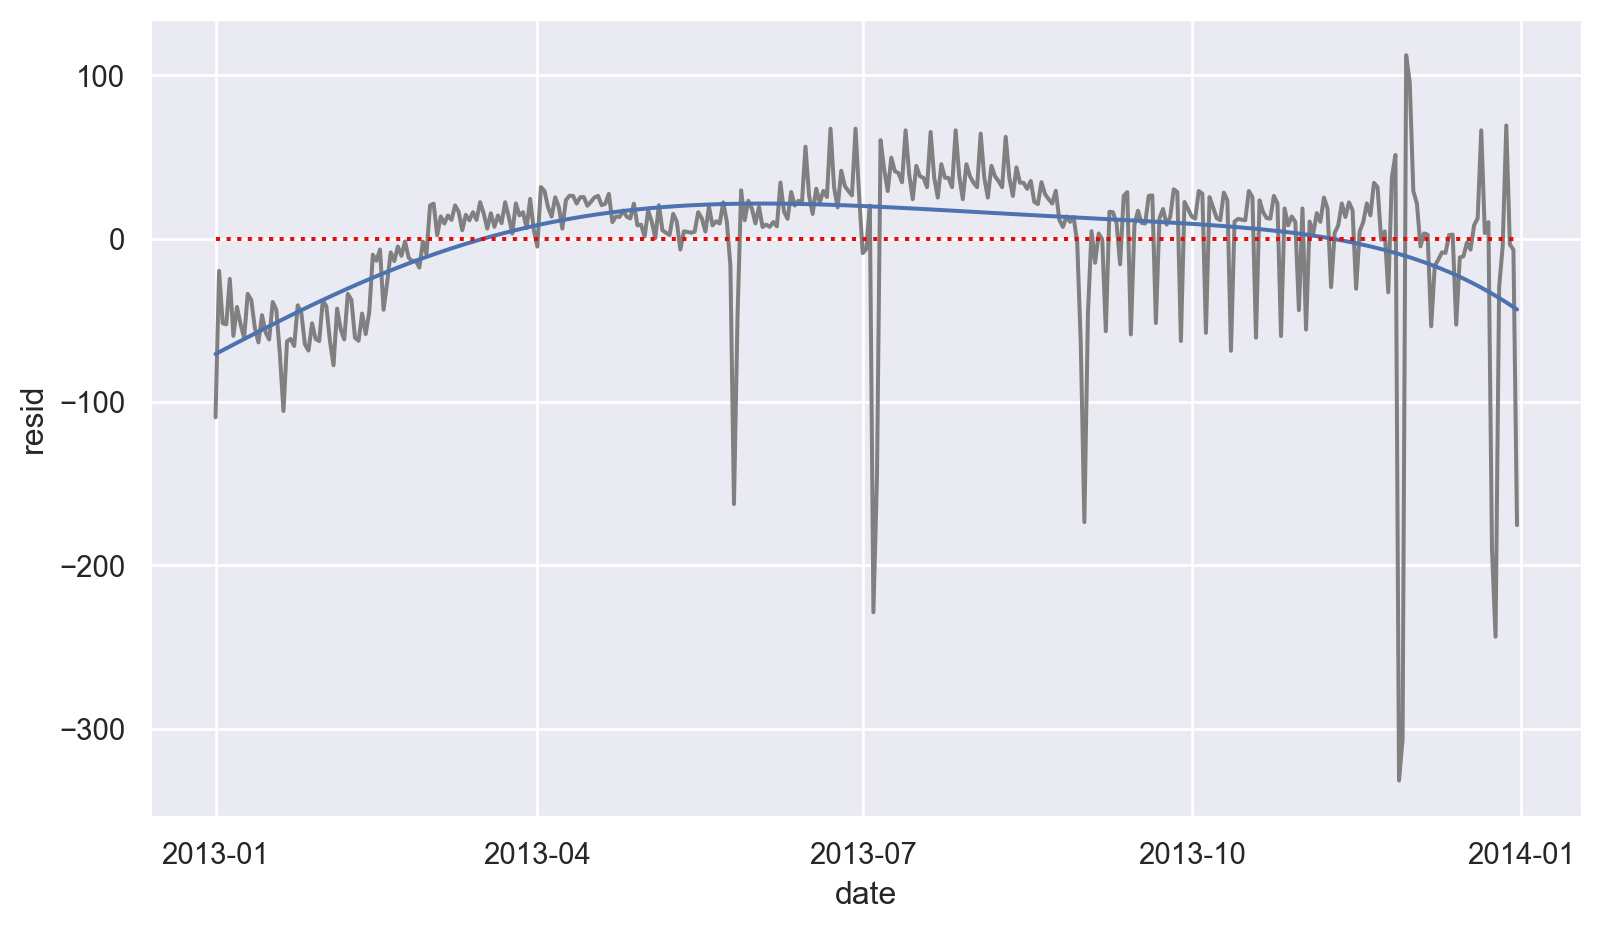

In [22]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line(color=".5"))
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red", linestyle=":"), x=ref_line.x, y=ref_line.y)
    .layout(size=(8.5, 5))
)

Natural spline fit  
`patsy` 패키지의 `cr` 함수를 이용

In [23]:
daily["day"] = daily["date"].dt.day_of_year

In [24]:
fit_spline = ols("resid ~ cr(day, df=10)", data=daily).fit()

In [25]:
daily["fitted"] = fit_spline.fittedvalues

In [26]:
daily.head(7)

        date    n wday   resid  day  fitted
0 2013-01-01  842  Tue -109.36    1  -56.91
1 2013-01-02  943  Wed  -19.69    2  -56.86
2 2013-01-03  914  Thu  -51.75    3  -56.80
3 2013-01-04  915  Fri  -52.46    4  -56.75
4 2013-01-05  720  Sat  -24.62    5  -56.68
5 2013-01-06  832  Sun  -59.48    6  -56.61
6 2013-01-07  933  Mon  -41.81    7  -56.54

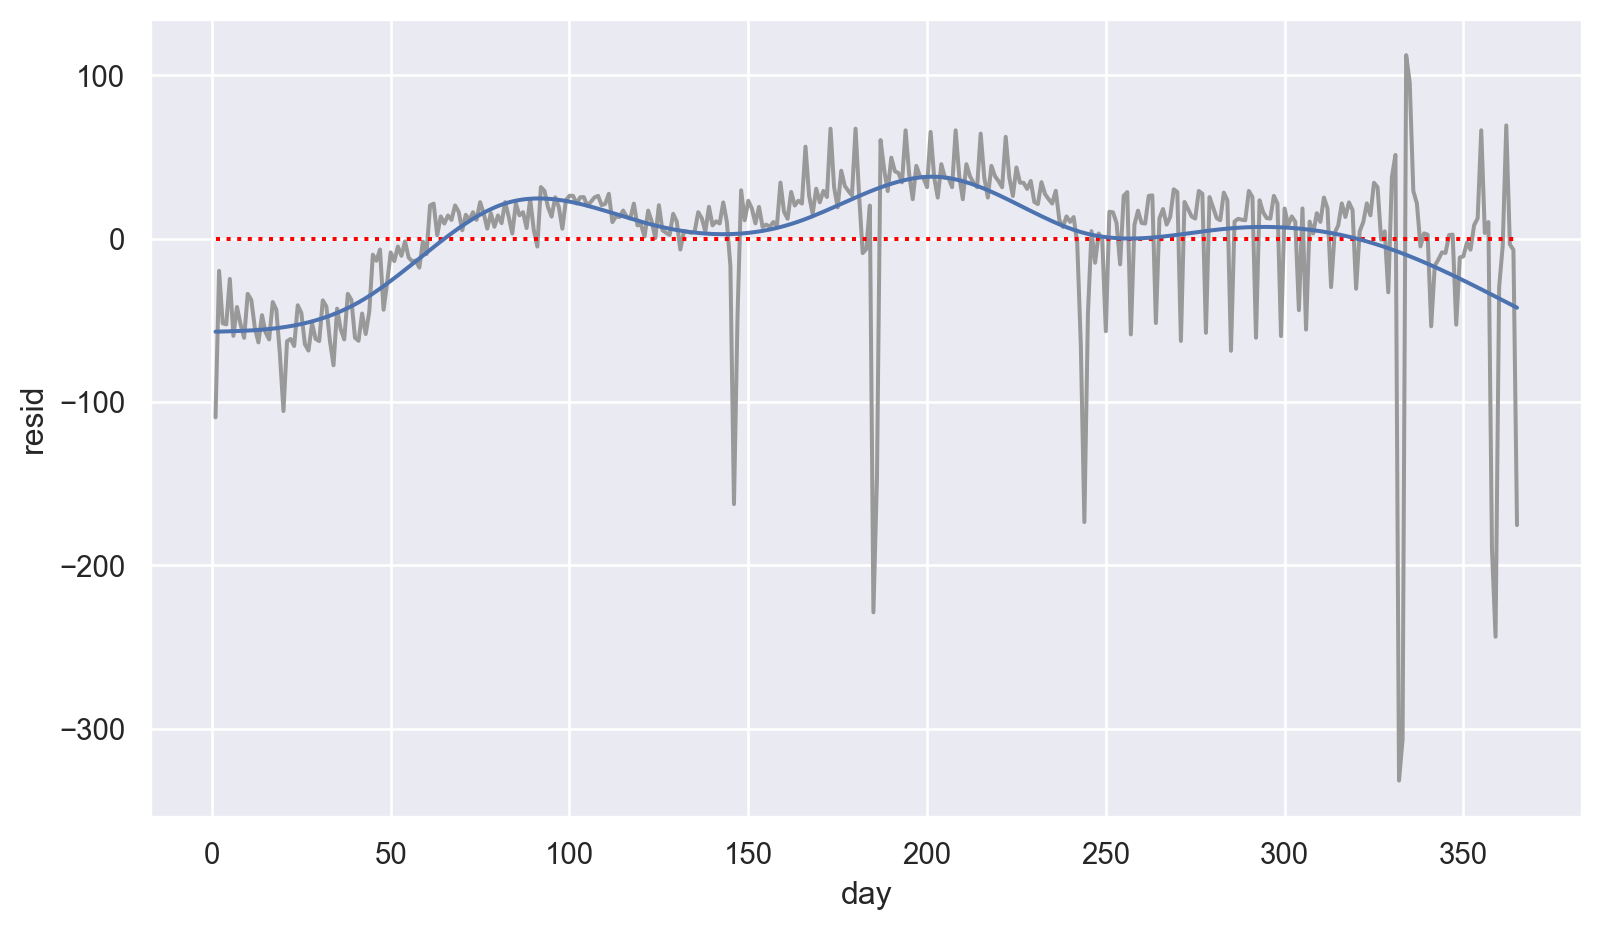

In [27]:
ref_line = pd.DataFrame({"x": [1, 365], "y": [0, 0]})

(
    so.Plot(daily, x='day', y='resid')
    .add(so.Line(color=".6"))
    .add(so.Line(color="red", linestyle=":"), x=ref_line.x, y=ref_line.y)
    .add(so.Line(), x=daily.day, y=daily.fitted)
    .layout(size=(8.5, 5))
)

겨울에 좀 적으며, 여름에 많음: 여러 해의 데이터가 있다면 이 패턴을 구체화 할 수 있으나 2013년의 데이터만 있으므로 우리의 지식에 의존해서 설명해 볼 수 밖에 없음

## 2. Seasonal Saturday effect (계절)

위의 첫번째 부분, 즉 토요일에 대해 나타나는 패턴을 잡아내기 위해

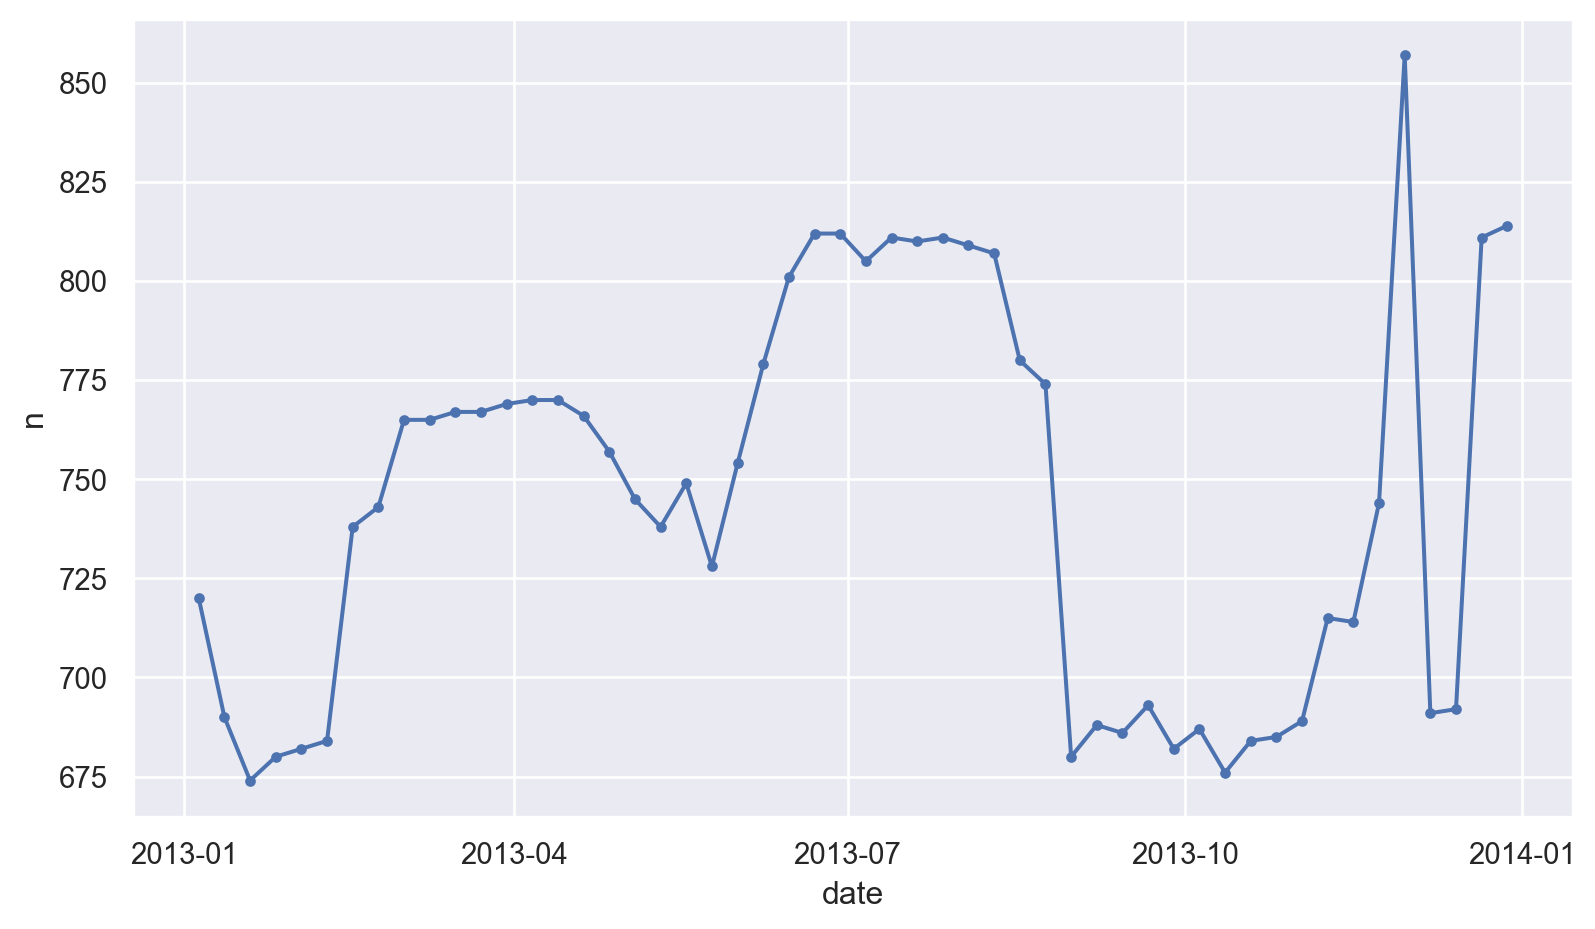

In [28]:
(
    so.Plot(daily.query('wday == "Sat"'), x='date', y='n')
    .add(so.Line(marker="."))
    .layout(size=(8.5, 5))
)

- 여름에는 토요일에 여행하는 걸 마다하지 않는 것은 아마도 여름 방학이나 휴가철이라 그런 것일 듯,  
  state’s school terms: summer break in 2013 was Jun 26–Sep 9
    
- 가을에 토요일 항공편이 적은 것은 미국에서는 추수감사절이나 크리스마스와 같은 큰 공휴일들이 있어 가족여행을 계획하지 않는다고 하는데 추측해 볼 뿐임.
  
대략 3개의 school terms으로 나누어 우리의 추측을 확인해보고자 함

In [29]:
dates_cut = pd.to_datetime(["2013-01-01", "2013-06-05", "2013-08-25", "2014-01-01"])
daily["term"] = pd.cut(daily.date, dates_cut, right=False, labels=["spring", "summer", "fall"])

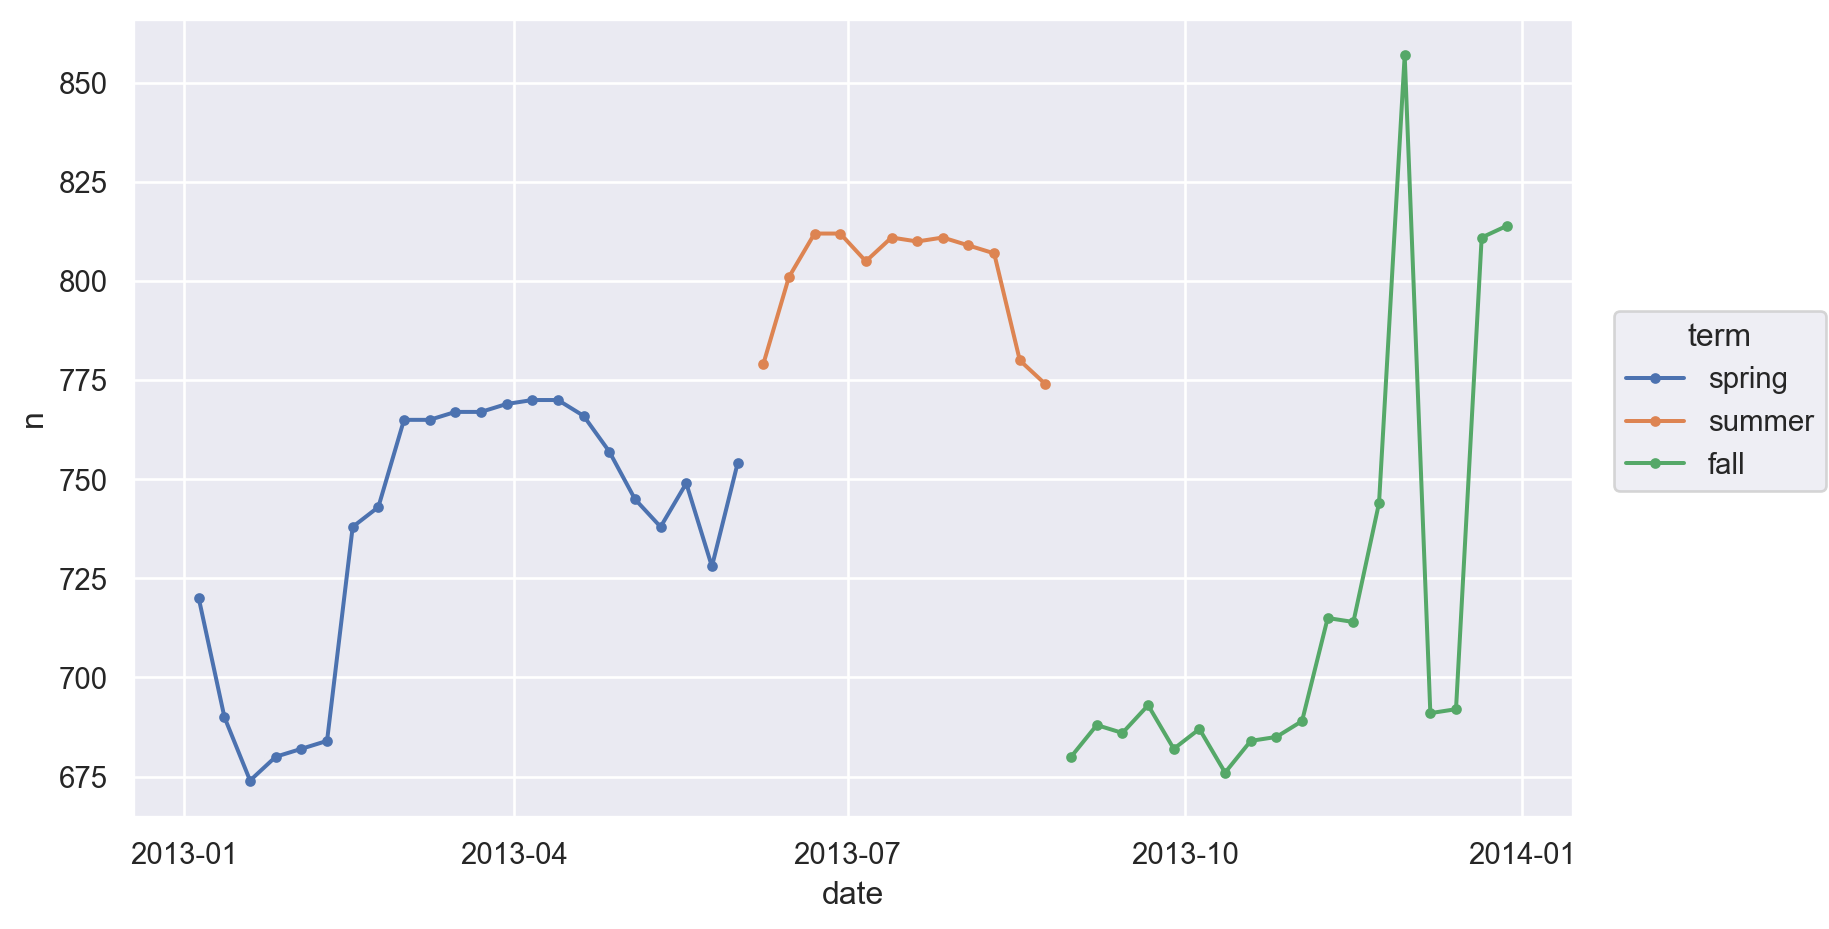

In [30]:
(
    so.Plot(daily.query('wday == "Sat"'), x='date', y='n', color="term")
    .add(so.Line(marker="."))
    .layout(size=(8.5, 5))
)

이 term 변수가 토요일이 아닌 다른 요일에는 어떻게 작용하는지 살펴보면

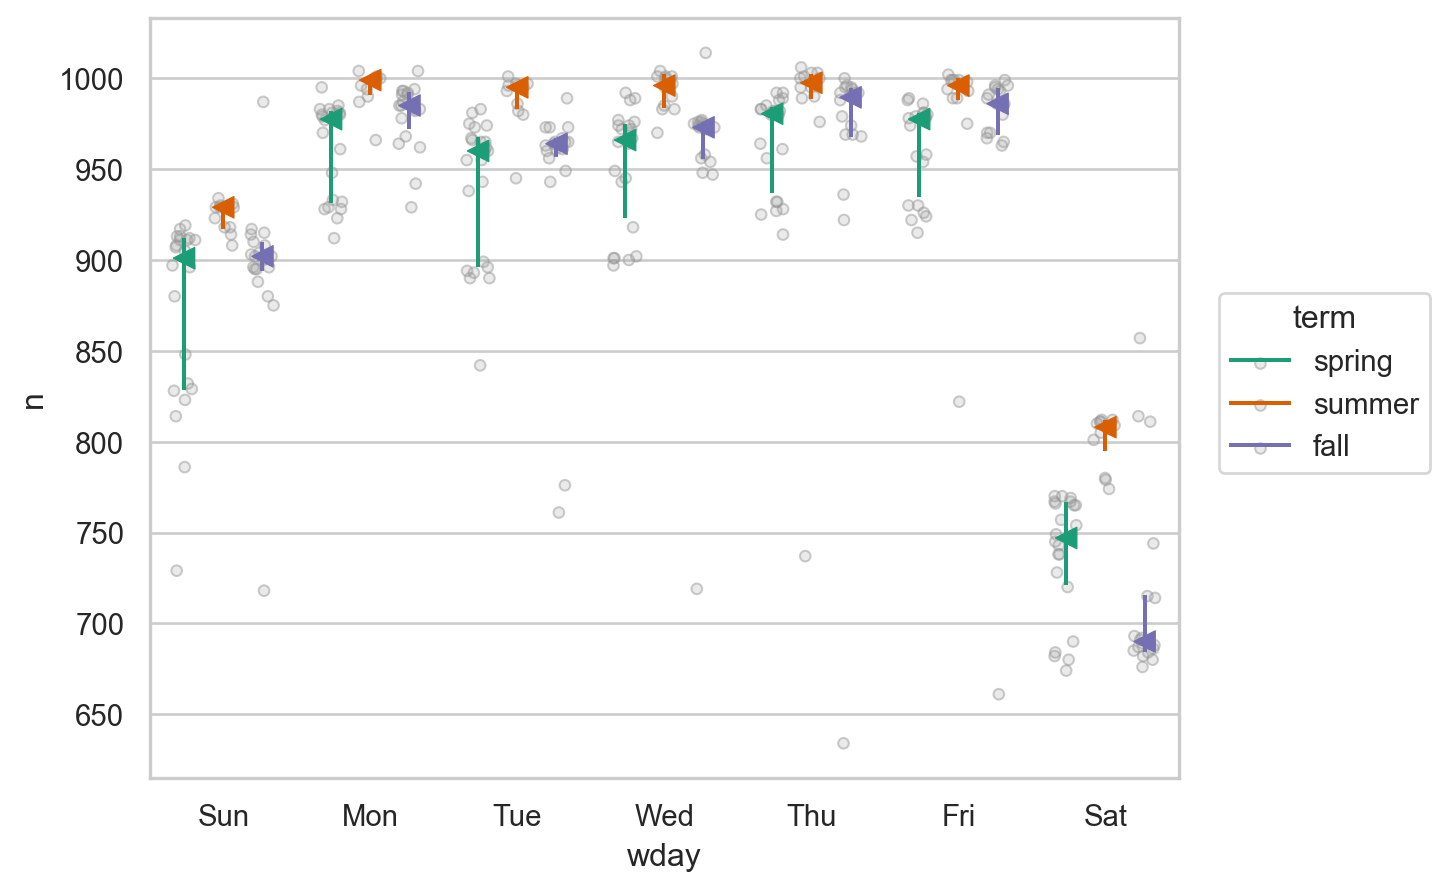

In [31]:
sbcustom.boxplot(daily, x="wday", y="n", color="term", alpha=.5)

3개의 term에 따라 각 요일에서의 항공편의 개수가 큰 차이가 나는 것으로 보이며, 그 패턴이 요일마다 다른 것으로 보이므로, 각 term에 따라 요일의 효과를 분리해서 보는 것이 타당해보임.  

## Model building
앞에서 탐색한 결과를 바탕으로, 하루에 출항하는 항공편의 개수를 예측하는데

1. 요일로만 예측하는 모델 (`mod1`)과
2. 요일과 term, 그리고 그 둘의 상호작용을 함께 고려한 모델 (`mod2`)을 세워 비교해보면,

In [32]:
mod1 = ols("n ~ wday", data=daily).fit()  # 요일로만 예측
mod2 = ols("n ~ wday * term", data=daily).fit()  # 요일과 term, 그리고 요일과 term의 interaction으로 예측

In [33]:
daily = daily.assign(
    without_term = mod1.resid,
    with_term = mod2.resid,
)

In [34]:
daily

          date    n wday   resid  day  fitted    term  without_term  with_term
0   2013-01-01  842  Tue -109.36    1  -56.91  spring       -109.36     -98.26
1   2013-01-02  943  Wed  -19.69    2  -56.86  spring        -19.69      -8.64
2   2013-01-03  914  Thu  -51.75    3  -56.80  spring        -51.75     -51.36
..         ...  ...  ...     ...  ...     ...     ...           ...        ...
362 2013-12-29  888  Sun   -3.48  363  -39.96    fall         -3.48      -7.00
363 2013-12-30  968  Mon   -6.81  364  -41.10    fall         -6.81     -11.26
364 2013-12-31  776  Tue -175.36  365  -42.24    fall       -175.36    -167.58

[365 rows x 9 columns]

In [35]:
daily_models = daily.melt(id_vars=["date"], value_vars=["without_term", "with_term"], var_name="model", value_name="residual")

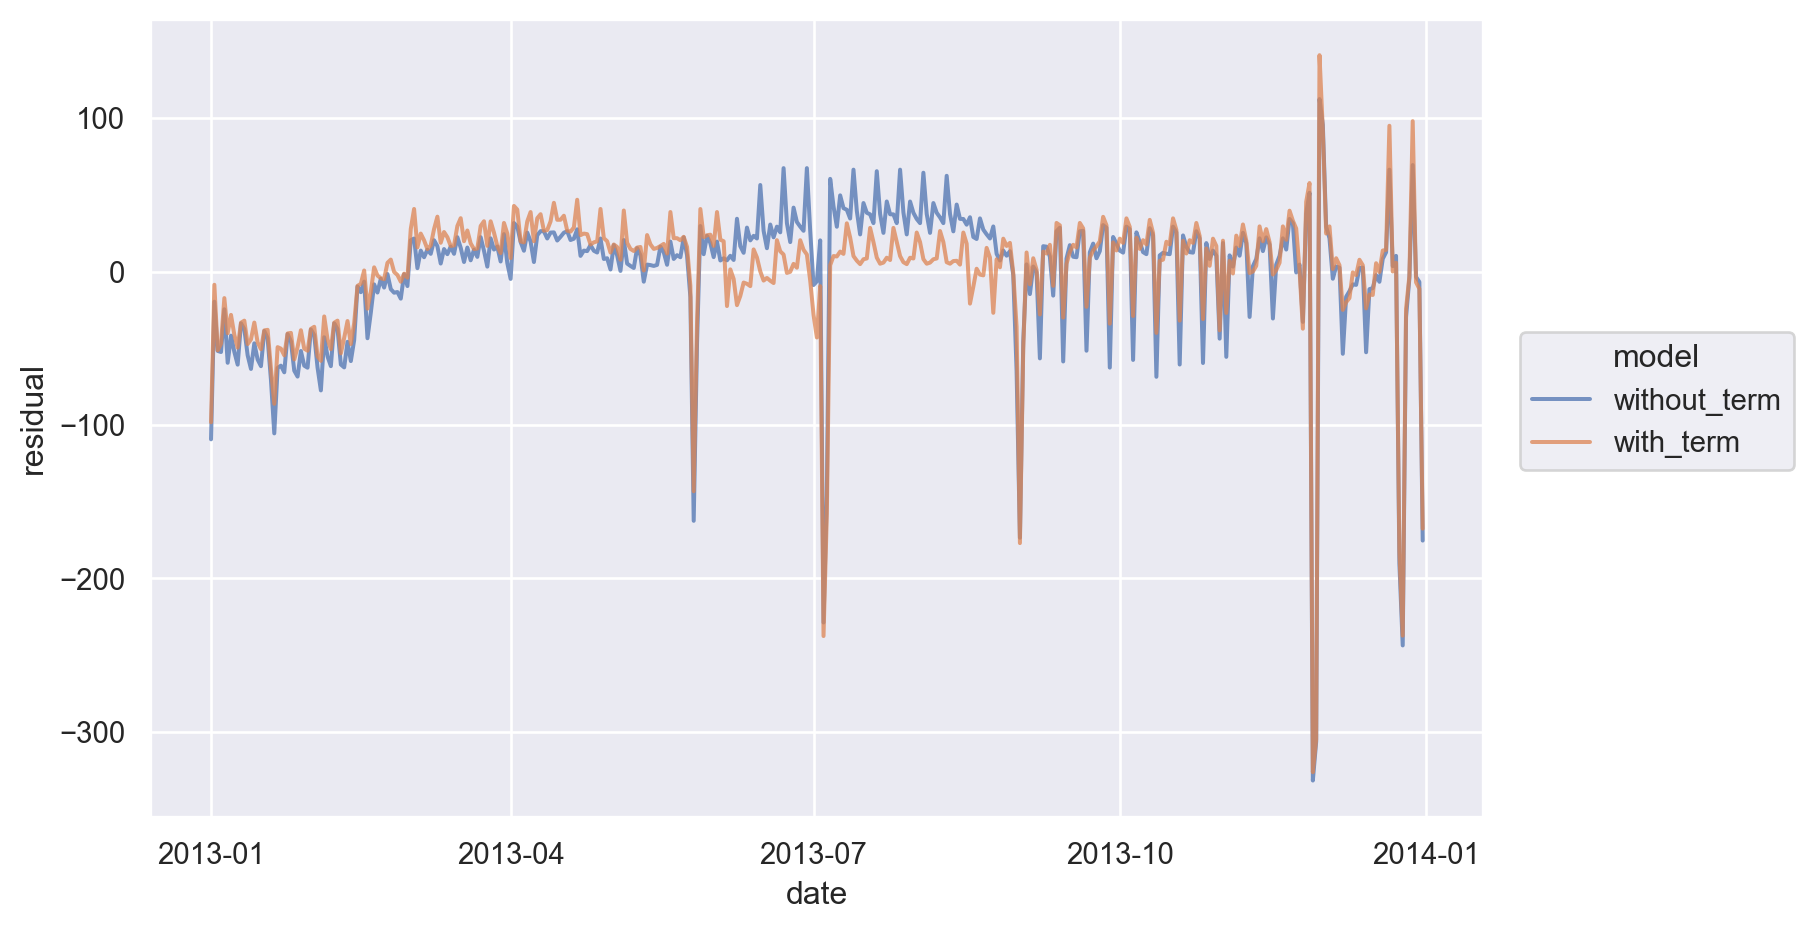

In [36]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line(alpha=.75))
    .layout(size=(8, 5))
)

Interaction이 있는 모델이 약간 나아보이나 좀 더 살펴보고자, 원래의 데이터와 함께 플랏을 그려보면,

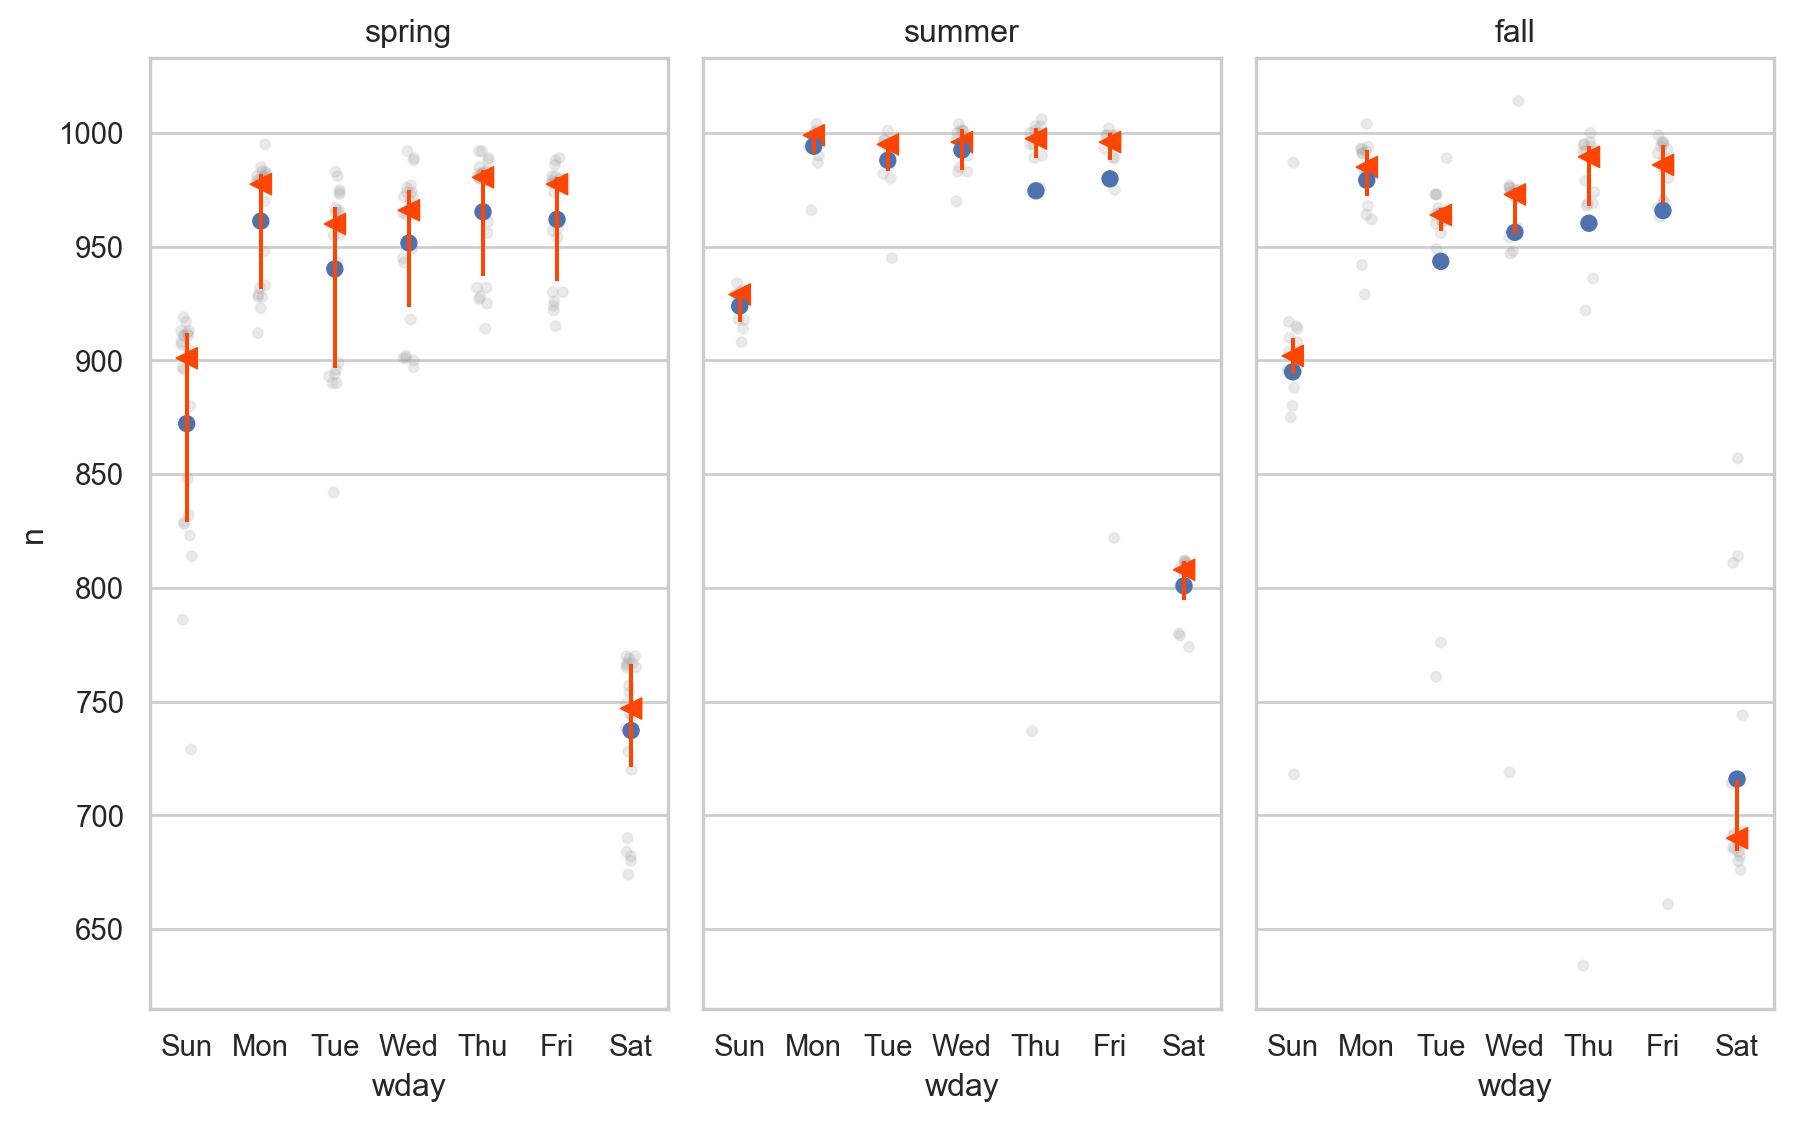

In [37]:
(
    sbcustom.boxplot(daily, x="wday", y="n")
    .add(so.Dot(), so.Agg())
    .facet("term")
    .layout(size=(9.5, 6))
)

이상치(ourliers)가 많아 평균(mean)의 값이 중앙값 (median)보다 많이 내려와 있는 경향을 보이고 있음.  
이는 이상치가 모델에 큰 영향을 미치기 때문인데, 이상치의 영향을 줄이는 방법 중에 하나인 **robust regression** 모형 (`mod3`)을 세워 해결해보면,

In [38]:
mod3 = sm.RLM.from_formula("n ~ wday * term", data=daily).fit()

In [39]:
#| echo: false
# data grid from wday and term
# wday_grid = pd.Categorical(
#     ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
#     categories=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
# )
# term_grid = pd.Categorical(
#     ["spring", "summer", "fall"],
#     categories=["spring", "summer", "fall"]
# )


In [40]:
wday_grid = np.array(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
term_grid = np.array(["spring", "summer", "fall"])

In [41]:
# meshgrid of wday and term
wday_grid, term_grid = np.meshgrid(wday_grid, term_grid)
grid = pd.DataFrame({"wday": wday_grid.ravel(), "term": term_grid.ravel()})

grid

   wday    term
0   Sun  spring
1   Mon  spring
2   Tue  spring
..  ...     ...
18  Thu    fall
19  Fri    fall
20  Sat    fall

[21 rows x 2 columns]

In [42]:
grid["interaction_ols"] = mod2.predict(grid[["wday", "term"]])
grid["interaction_rlm"] = mod3.predict(grid[["wday", "term"]])

In [43]:
grid

   wday    term  interaction_ols  interaction_rlm
0   Sun  spring           872.23           893.50
1   Mon  spring           961.27           966.16
2   Tue  spring           940.26           952.84
..  ...     ...              ...              ...
18  Thu    fall           960.33           981.54
19  Fri    fall           965.89           982.43
20  Sat    fall           716.00           696.90

[21 rows x 4 columns]

In [44]:
daily_median = daily.groupby(["wday", "term"])["n"].median().reset_index(name="median")

In [45]:
grid = grid.merge(daily_median, on=["wday", "term"])
grid

   wday    term  interaction_ols  interaction_rlm  median
0   Sun  spring           872.23           893.50  901.00
1   Mon  spring           961.27           966.16  977.50
2   Tue  spring           940.26           952.84  960.00
..  ...     ...              ...              ...     ...
18  Thu    fall           960.33           981.54  989.50
19  Fri    fall           965.89           982.43  986.00
20  Sat    fall           716.00           696.90  690.00

[21 rows x 5 columns]

In [46]:
grid_long = grid.melt(id_vars=["wday", "term"], value_vars=["interaction_ols", "interaction_rlm", "median"], var_name="model", value_name="n")
grid_long

   wday    term            model      n
0   Sun  spring  interaction_ols 872.23
1   Mon  spring  interaction_ols 961.27
2   Tue  spring  interaction_ols 940.26
..  ...     ...              ...    ...
60  Thu    fall           median 989.50
61  Fri    fall           median 986.00
62  Sat    fall           median 690.00

[63 rows x 4 columns]

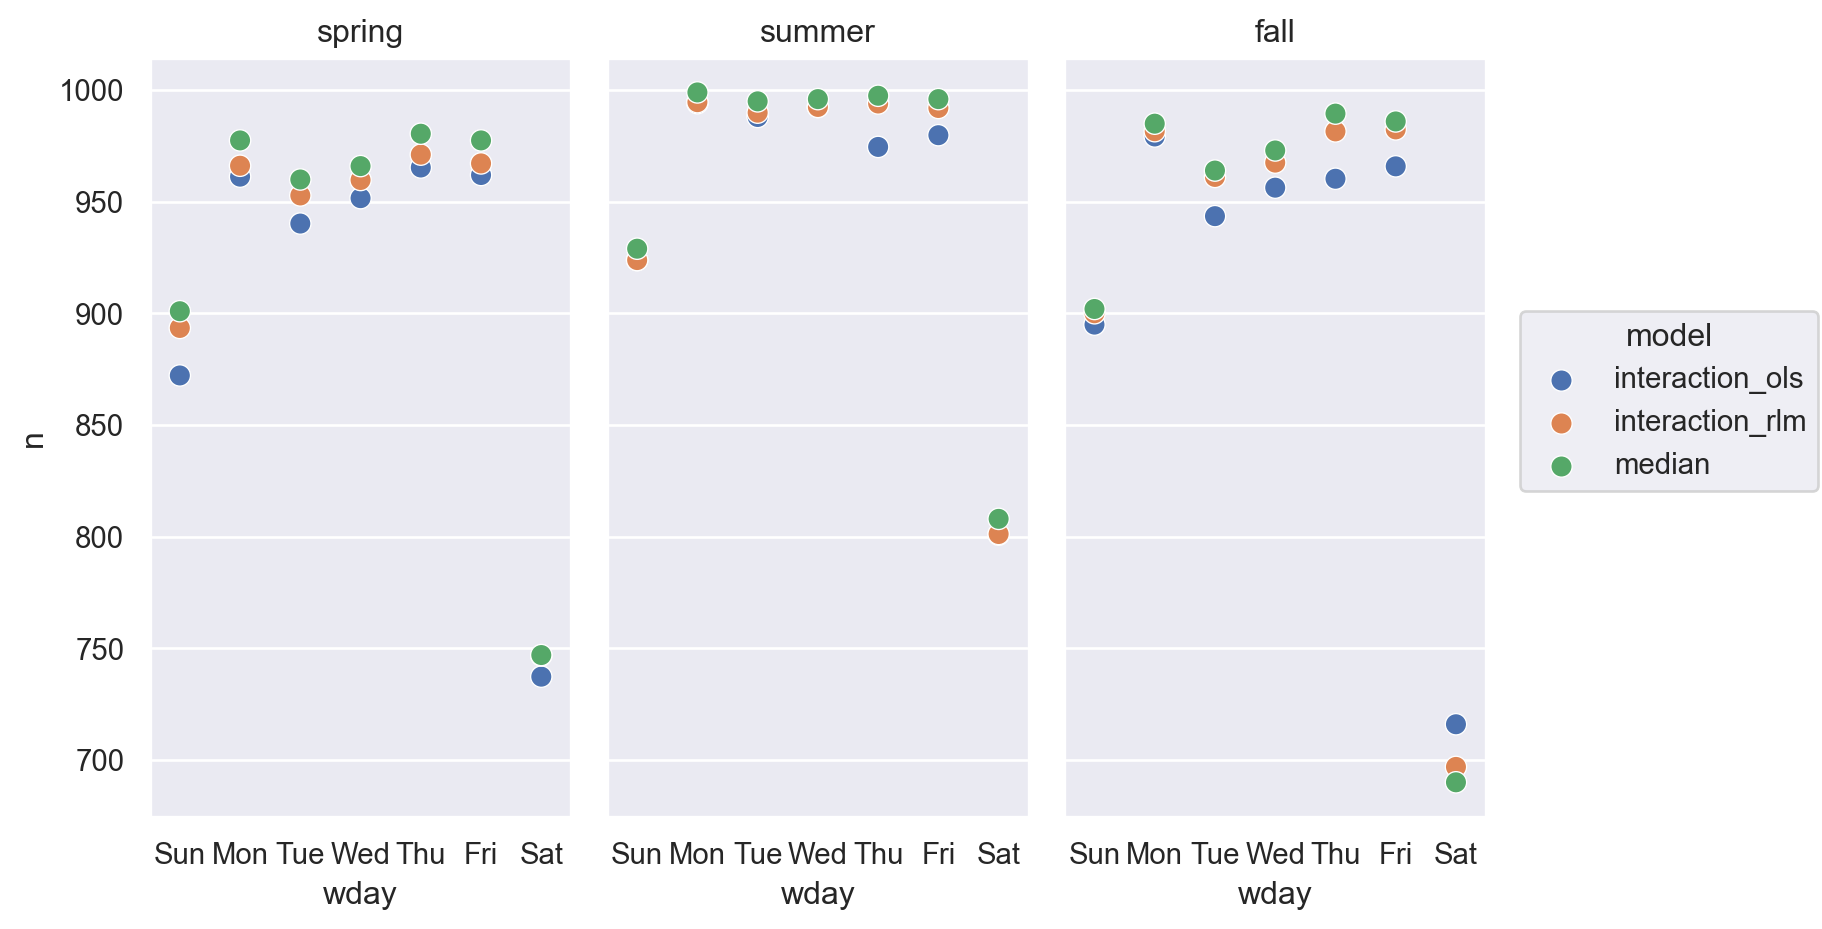

In [47]:
(
    so.Plot(grid_long, x='wday', y='n', color="model")
    .add(so.Dot(edgecolor="w", pointsize=8))
    .facet("term")
    .layout(size=(8, 5))
)

**Final model**  
`mod3 = sm.RLM.from_formula("n ~ wday * term", data=daily).fit()`

In [48]:
#| echo: false
pd.options.display.max_rows = 0

In [49]:
mod3.params

Intercept                     893.50
wday[T.Mon]                    72.65
wday[T.Tue]                    59.34
wday[T.Wed]                    66.27
wday[T.Thu]                    77.63
wday[T.Fri]                    73.70
wday[T.Sat]                  -146.68
term[T.summer]                 30.40
term[T.fall]                    6.58
wday[T.Mon]:term[T.summer]     -1.92
wday[T.Tue]:term[T.summer]      6.69
wday[T.Wed]:term[T.summer]      2.32
wday[T.Thu]:term[T.summer]     -7.51
wday[T.Fri]:term[T.summer]     -5.57
wday[T.Sat]:term[T.summer]     23.99
wday[T.Mon]:term[T.fall]        8.89
wday[T.Tue]:term[T.fall]        1.72
wday[T.Wed]:term[T.fall]        1.21
wday[T.Thu]:term[T.fall]        3.82
wday[T.Fri]:term[T.fall]        8.65
wday[T.Sat]:term[T.fall]      -56.51
dtype: float64

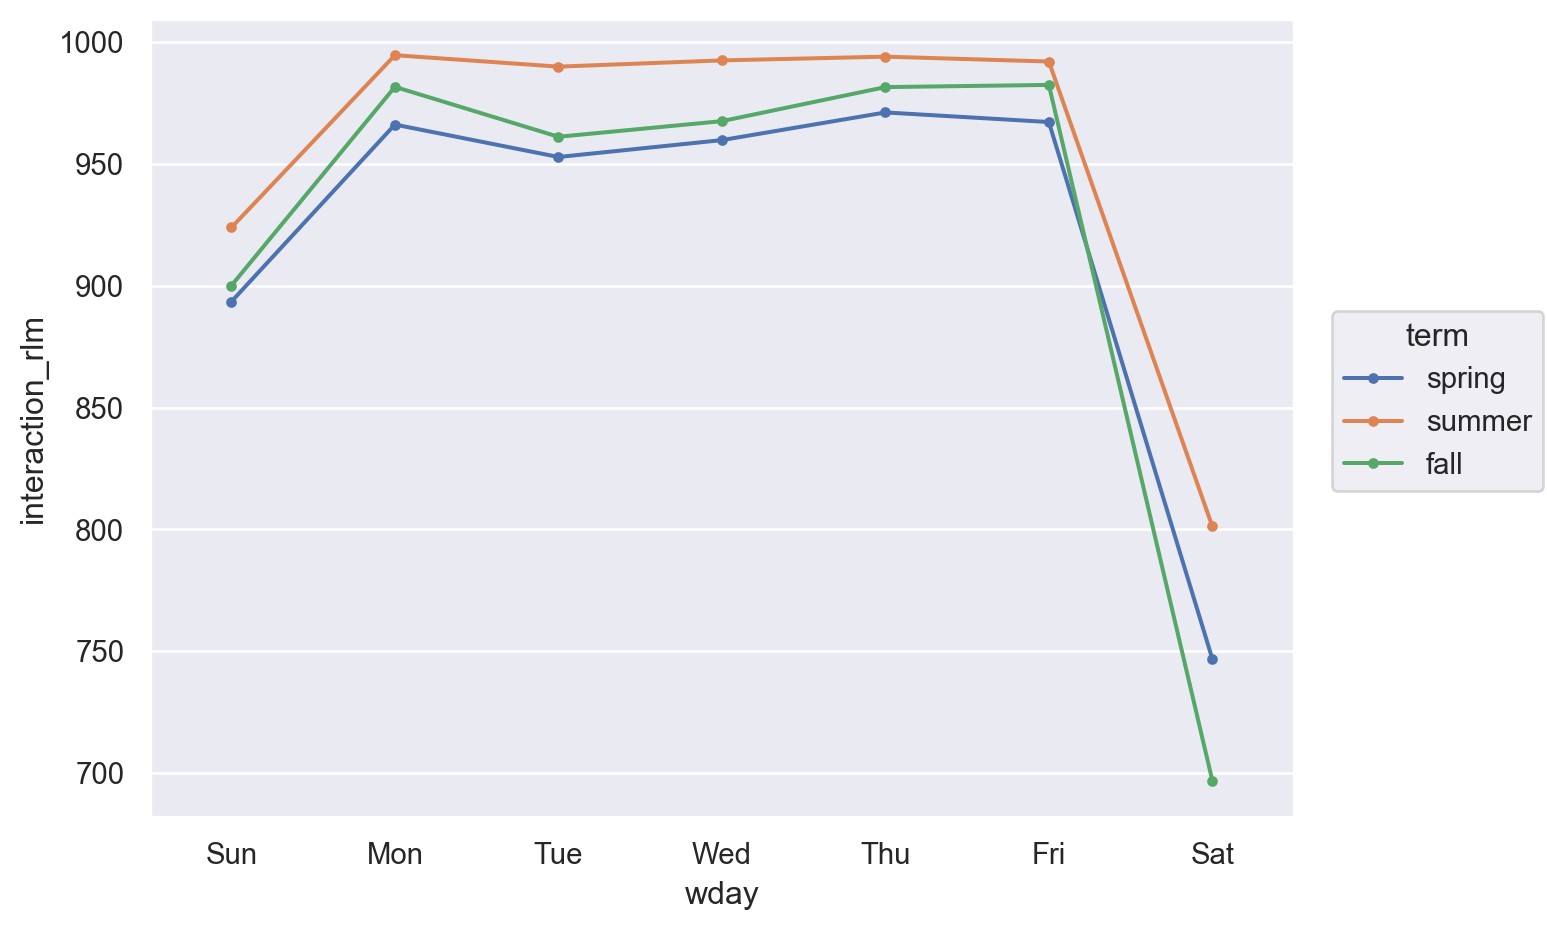

In [50]:
(
    so.Plot(grid, x='wday', y='interaction_rlm', color="term")
    .add(so.Line(marker="."))
    .layout(size=(7, 5))
)

Residuals for `mod3`

In [51]:
daily["with_term_rlm"] = mod3.resid

In [52]:
daily_models = daily.melt(
    id_vars=["date"],
    value_vars=["with_term", "with_term_rlm"],
    var_name="model",
    value_name="residual",
)

In [53]:
#| echo: false
pd.options.display.max_rows = 7

In [54]:
daily_models

          date          model  residual
0   2013-01-01      with_term    -98.26
1   2013-01-02      with_term     -8.64
2   2013-01-03      with_term    -51.36
..         ...            ...       ...
727 2013-12-29  with_term_rlm    -12.09
728 2013-12-30  with_term_rlm    -13.63
729 2013-12-31  with_term_rlm   -185.15

[730 rows x 3 columns]

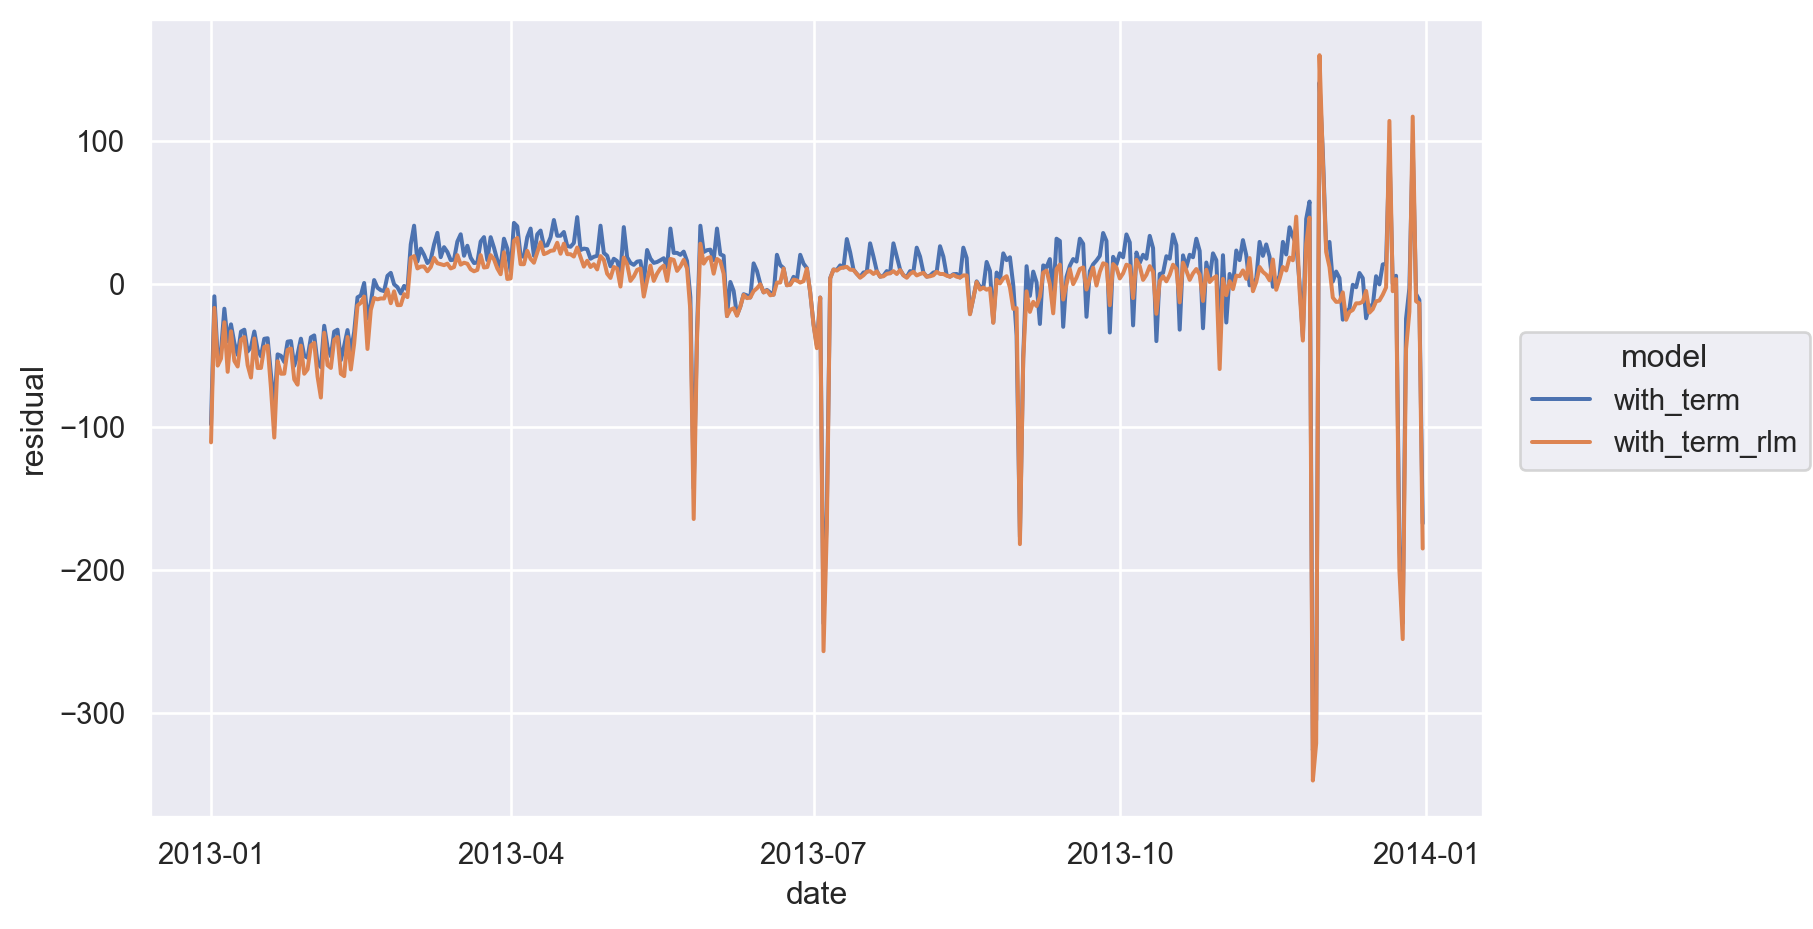

In [55]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line())
    .layout(size=(8, 5))
)

이제 1년에 걸친 장기 트렌드를 더 잘 볼 수 있고, positive한 이상치와 negative한 이상치도 확연히 들어남

## Time of year: an alternative approach

- 위에서는 모델을 향상시키기 위해 우리의 지식을 이용하였는데, 이에 반해
- 좀 더 유동적인 모델을 이용하여 데이터의 패턴을 잘 잡아내주도록 적절한 모델을 생성하는 방식도 있음
- 위의 예에서는 선형모델로는 부족하니 natural spline을 이용해서 부드러운 곡선에 fit해볼 수 있음

In [56]:
# data range for the plot of date vs. n
date_range = pd.date_range("2013-01-01", "2014-01-01", freq="D")

In [57]:
mod_spline = sm.RLM.from_formula("n ~ wday * cr(day, df=5)", data=daily).fit()

In [58]:
daily["fitted_spline"] = mod_spline.fittedvalues

In [59]:
daily

          date    n wday   resid  day  fitted    term  without_term  \
0   2013-01-01  842  Tue -109.36    1  -56.91  spring       -109.36   
1   2013-01-02  943  Wed  -19.69    2  -56.86  spring        -19.69   
2   2013-01-03  914  Thu  -51.75    3  -56.80  spring        -51.75   
..         ...  ...  ...     ...  ...     ...     ...           ...   
362 2013-12-29  888  Sun   -3.48  363  -39.96    fall         -3.48   
363 2013-12-30  968  Mon   -6.81  364  -41.10    fall         -6.81   
364 2013-12-31  776  Tue -175.36  365  -42.24    fall       -175.36   

     with_term  with_term_rlm  fitted_spline  
0       -98.26        -110.84         865.91  
1        -8.64         -16.78         888.63  
2       -51.36         -57.14         913.36  
..         ...            ...            ...  
362      -7.00         -12.09         885.37  
363     -11.26         -13.63         967.40  
364    -167.58        -185.15         935.67  

[365 rows x 11 columns]

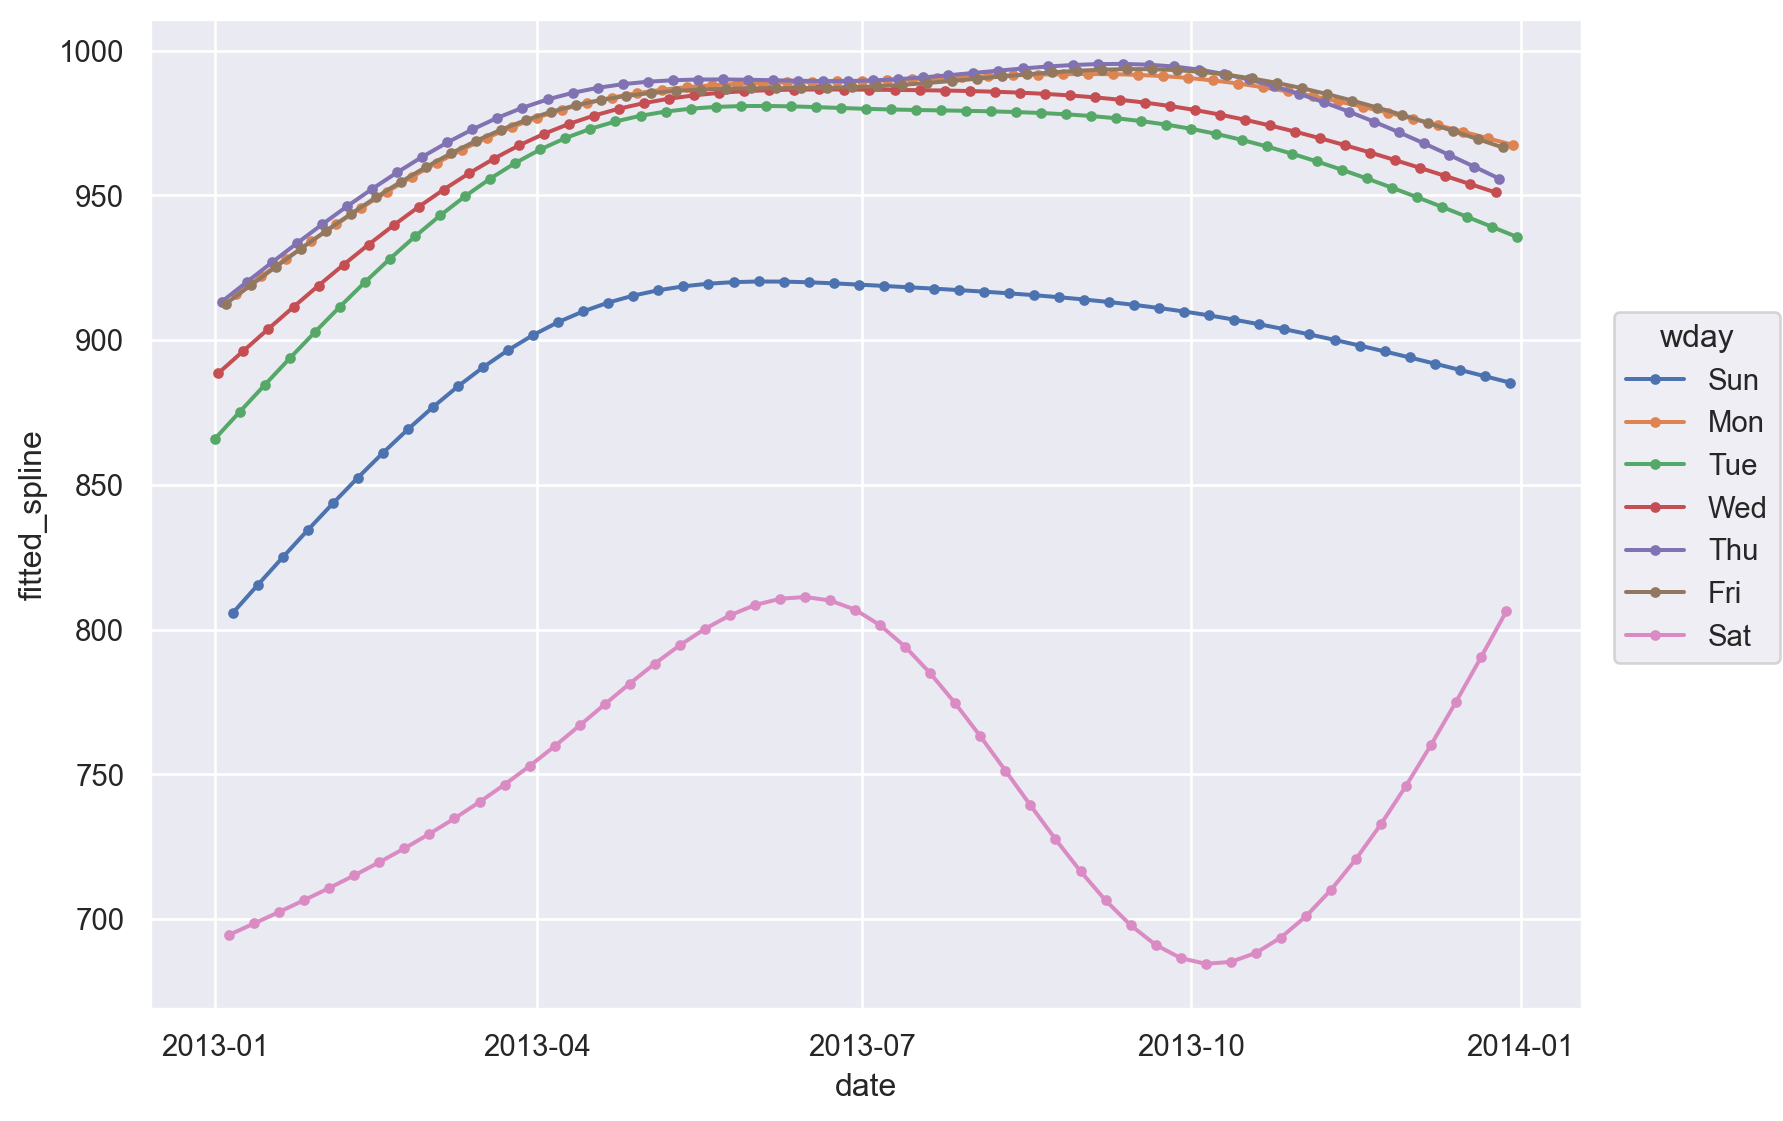

In [60]:
(
    so.Plot(daily, x='date', y='fitted_spline', color="wday")
    .add(so.Line(marker="."))
    .layout(size=(8.5, 6))
)

Residuals for `mod_spline`

In [61]:
daily["resid_spline"] = mod_spline.resid

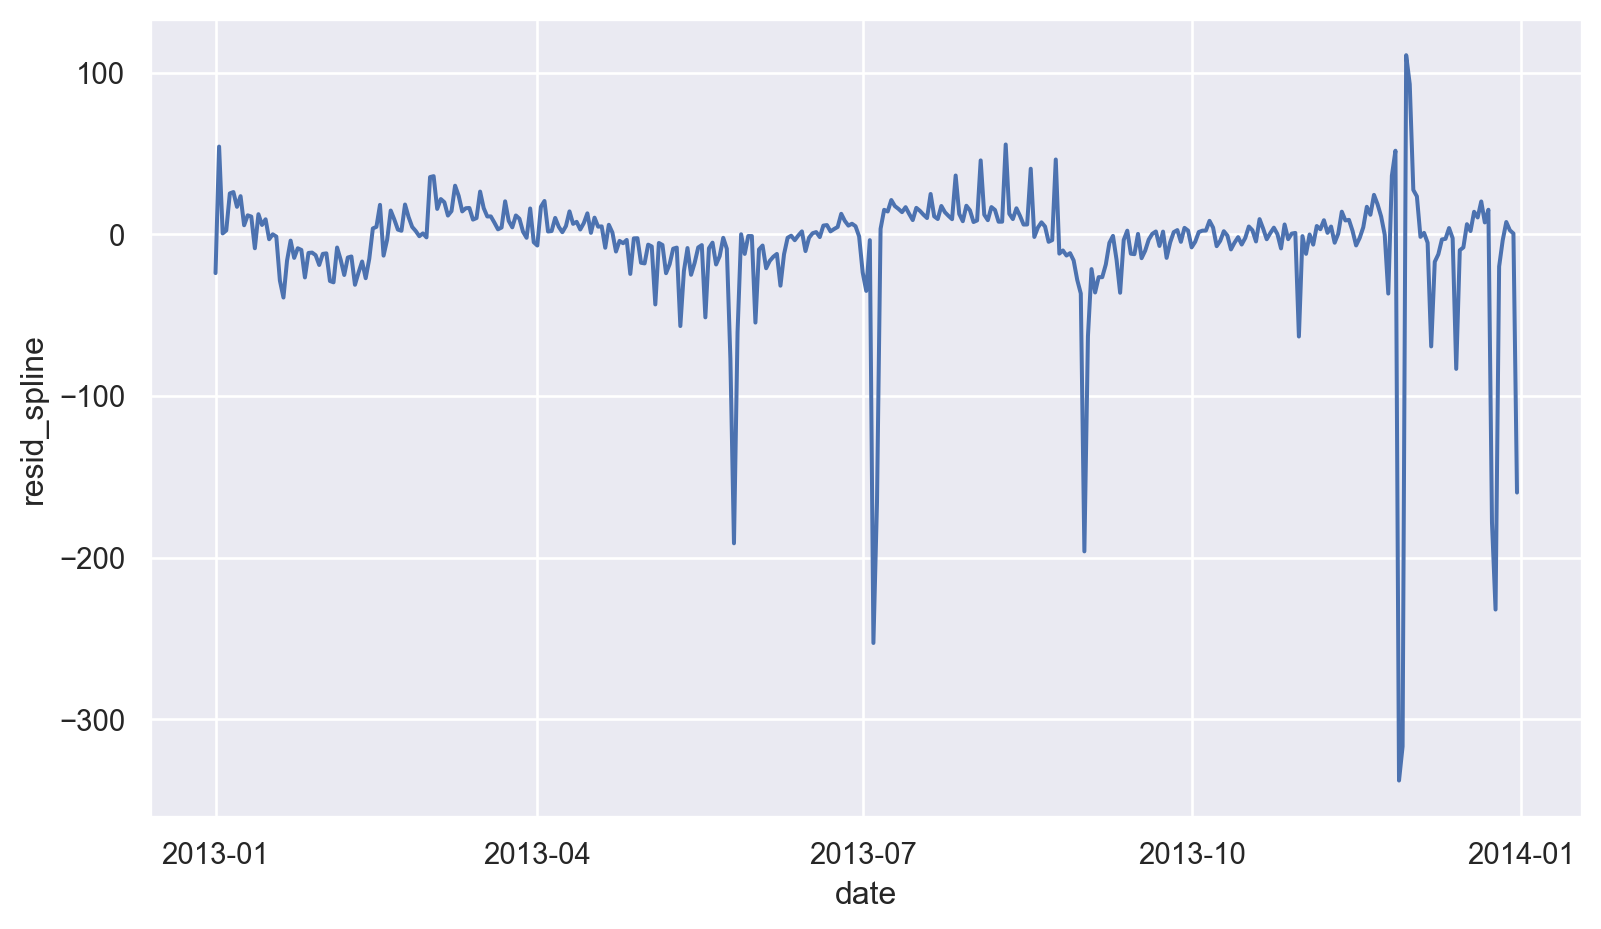

In [62]:
(
    so.Plot(daily, x='date', y='resid_spline')
    .add(so.Line())
    .layout(size=(8.5, 5))
)

좀 더 복잡한 모델; degree of freedom=10

In [64]:
mod_spline2 = sm.RLM.from_formula("n ~ wday * cr(day, df=10)", data=daily).fit()
daily["fitted_spline2"] = mod_spline2.fittedvalues

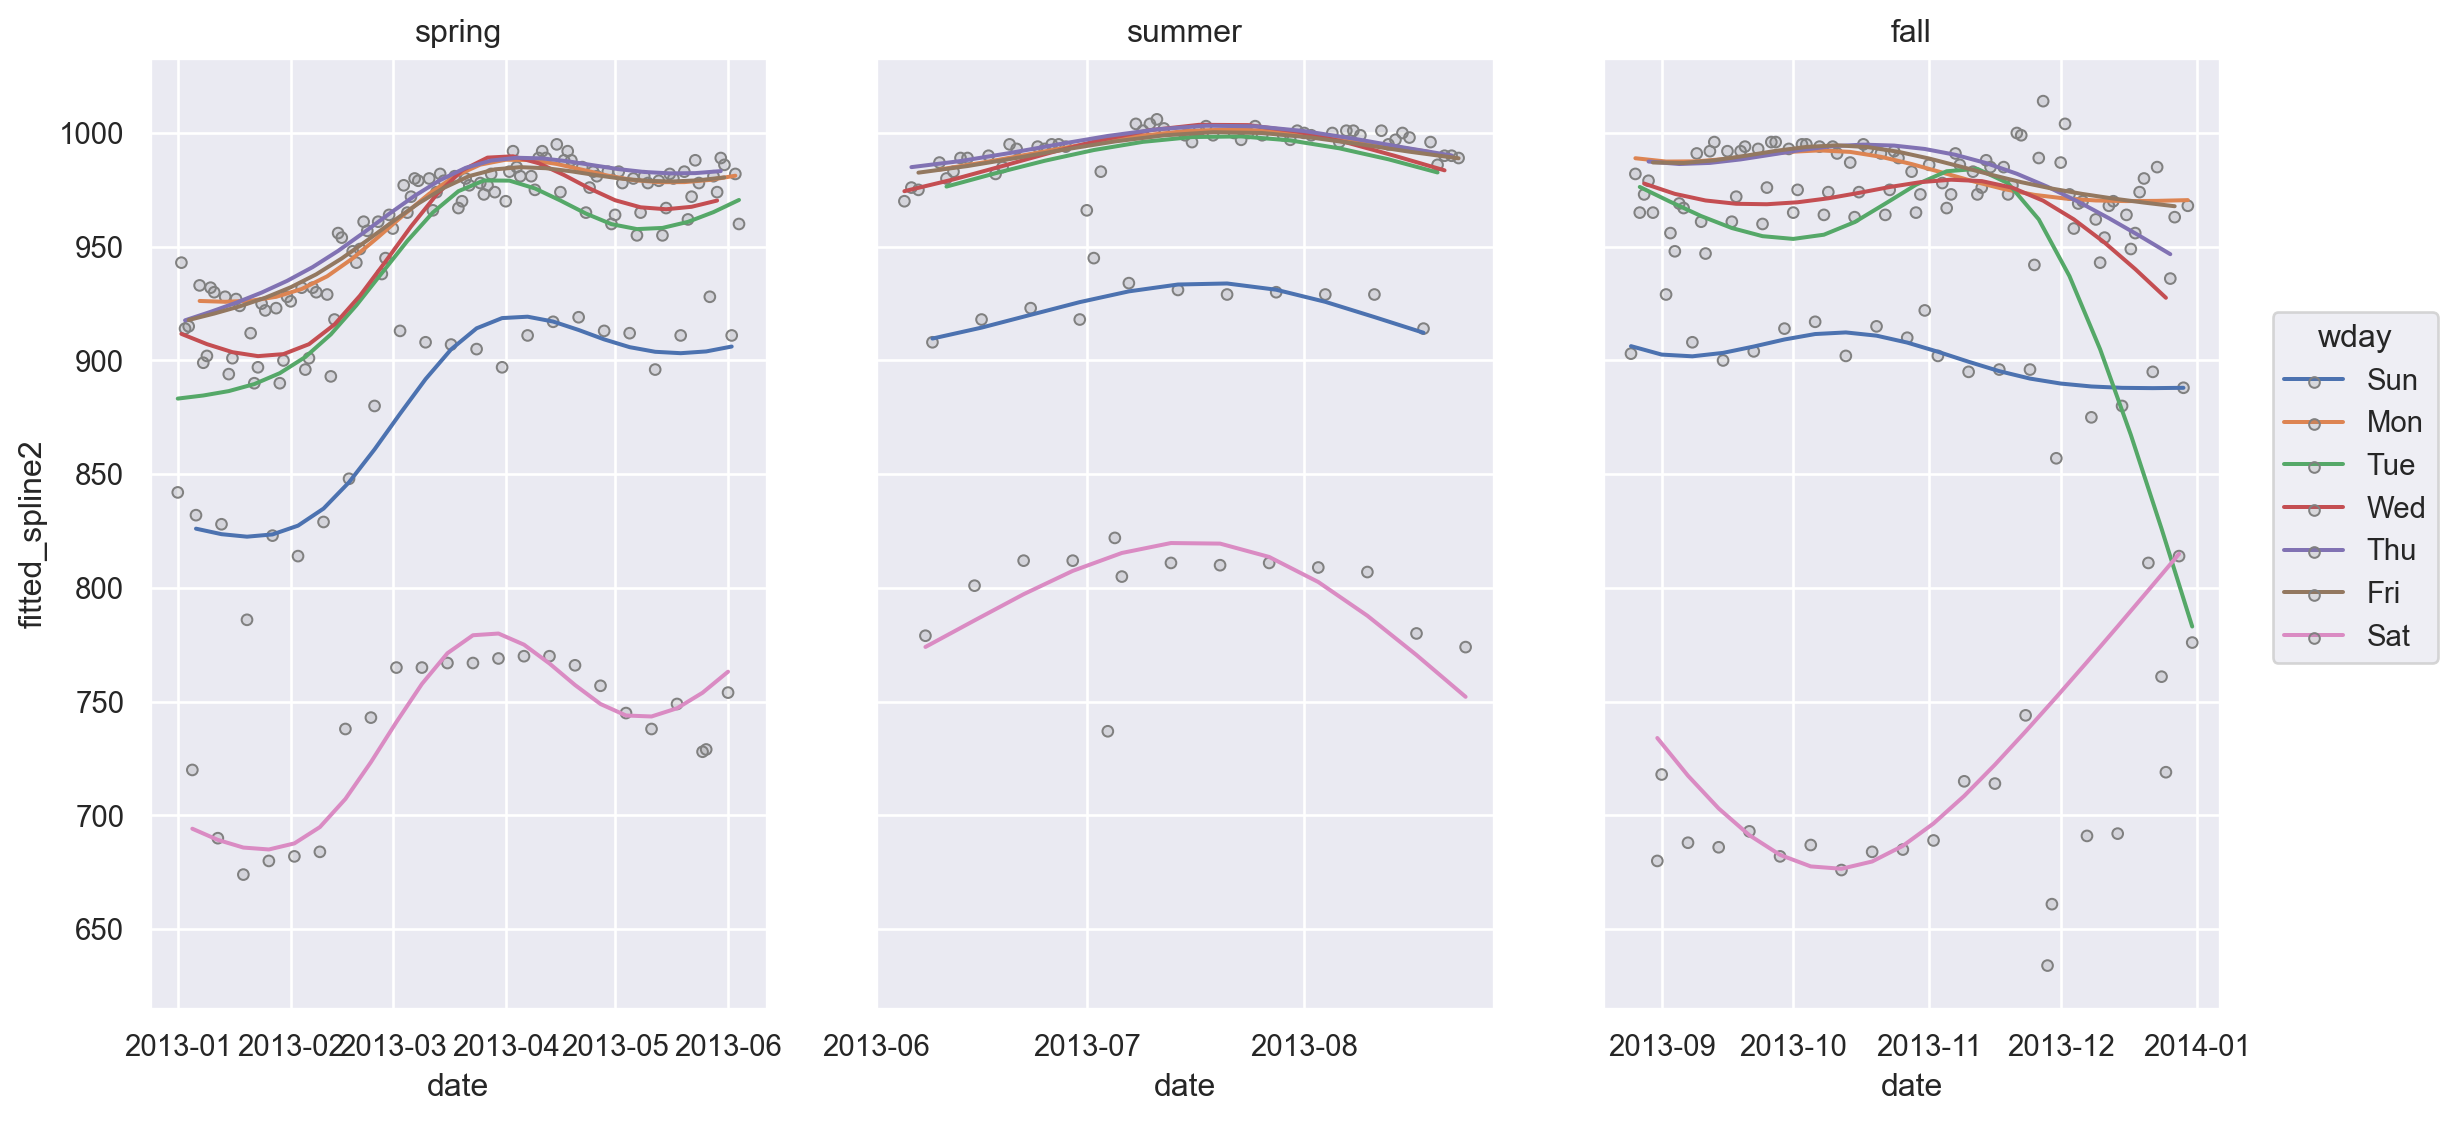

In [82]:
#| code-summary: Natural spline fit with df=10
#| code-fold: true
(
    so.Plot(daily, x='date', y='fitted_spline2', color="wday")
    .add(so.Line())
    .add(so.Dots(color='.5'), y="n")
    .layout(size=(8.5, 6))
    .facet("term")
    .share(x=False)
    .layout(size=(12, 6))
)

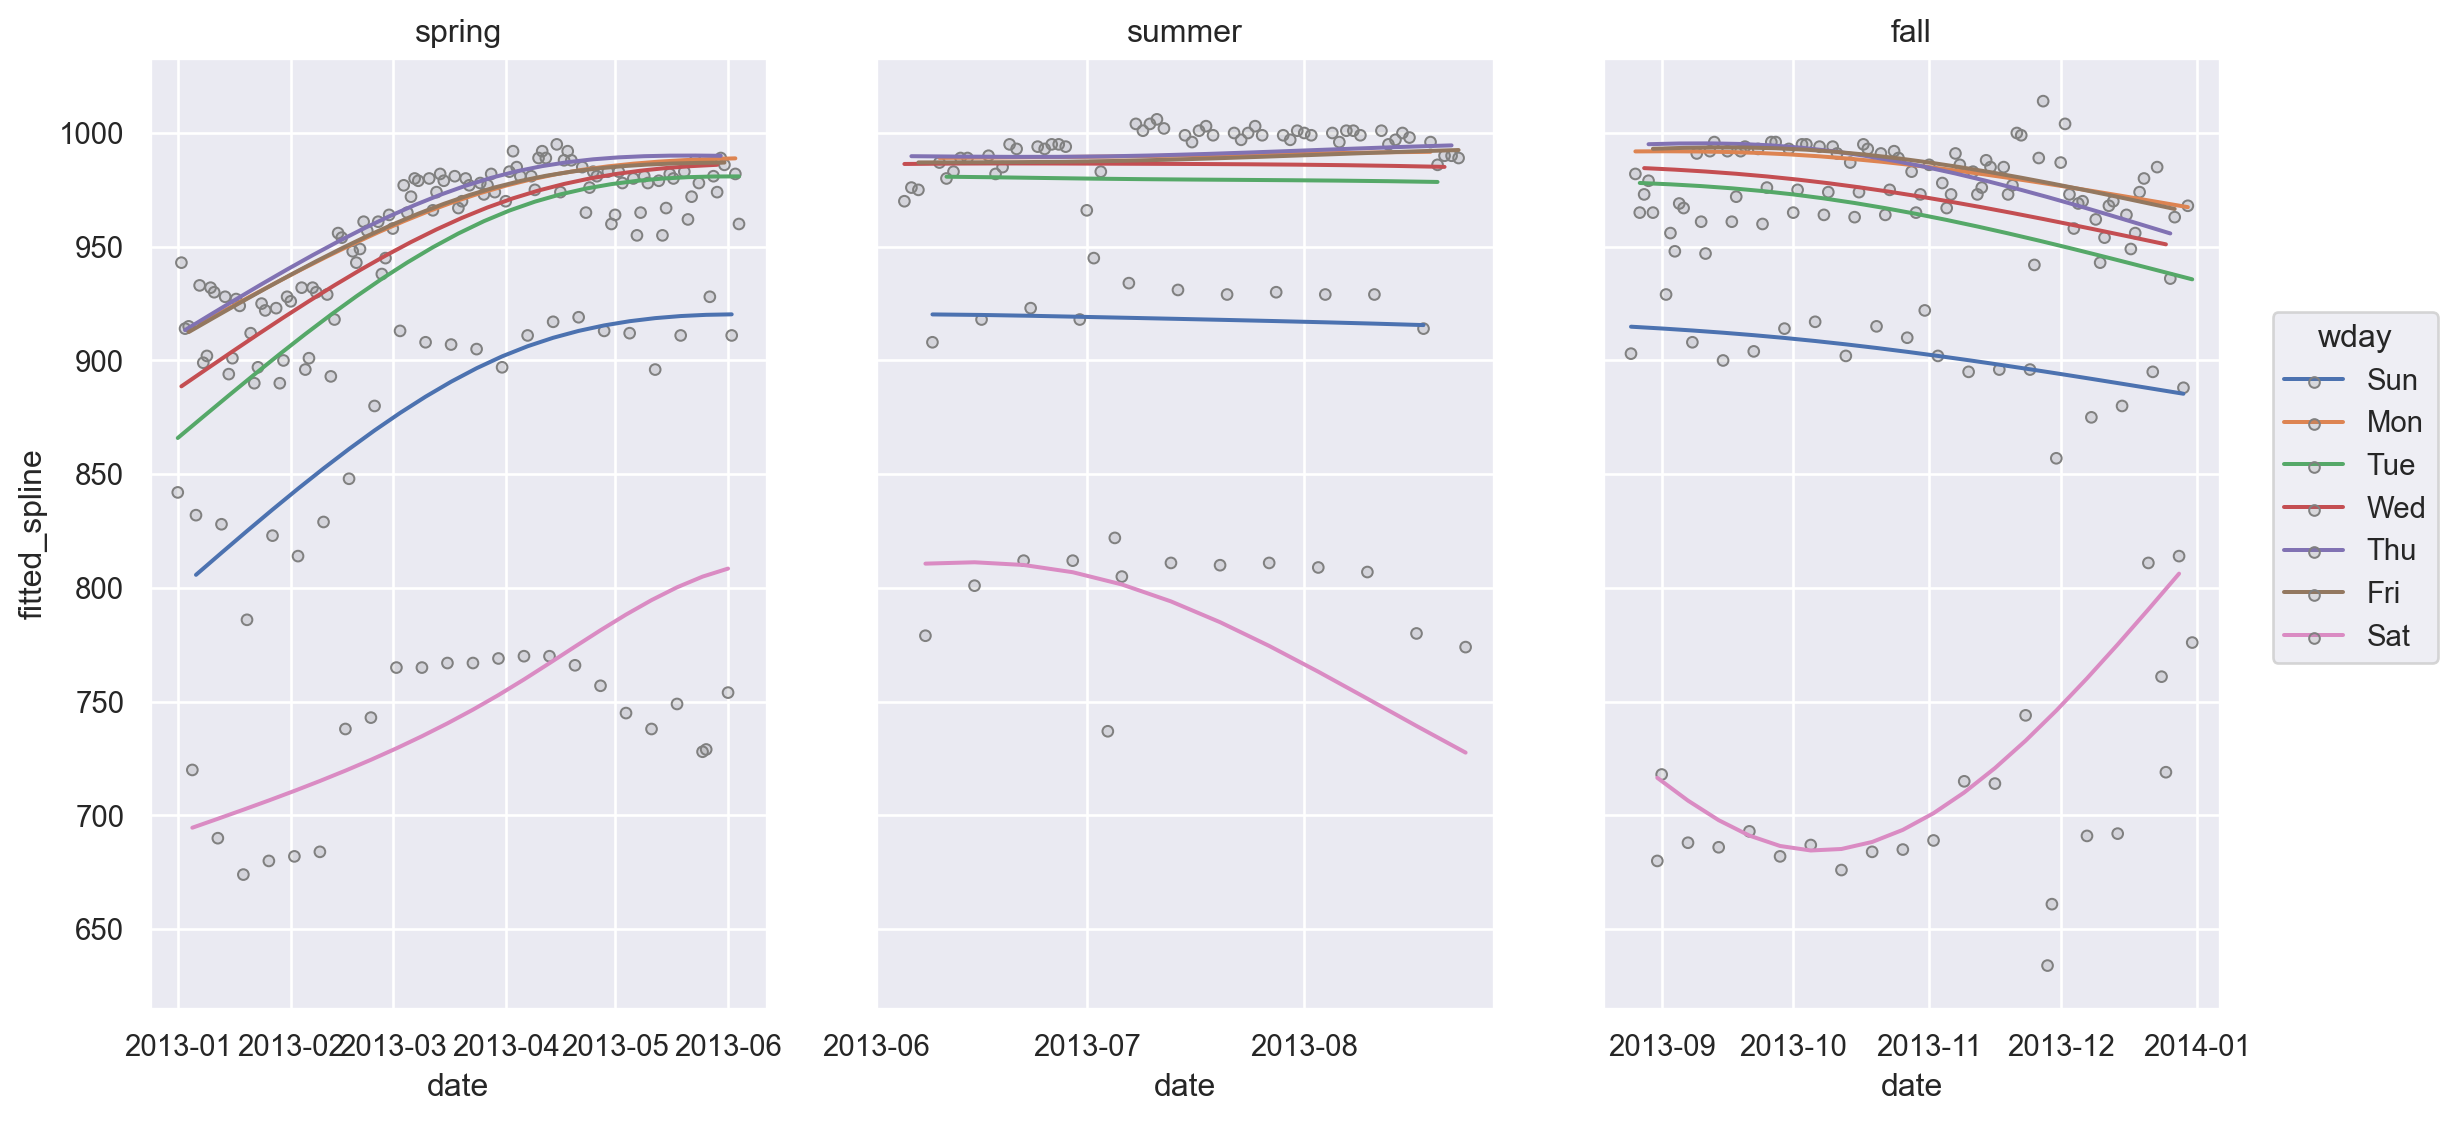

In [83]:
#| code-summary: Natural spline fit with df=5
#| code-fold: true
(
    so.Plot(daily, x='date', y='fitted_spline', color="wday")
    .add(so.Line())
    .add(so.Dots(color='.5'), y="n")
    .layout(size=(8.5, 6))
    .facet("term")
    .share(x=False)
    .layout(size=(12, 6))
)

## 연습문제

- Without interactions: what would you expect the model `n ~ wday + ns(date, 5)`to look like? Knowing what you know about the data, why would you expect it to be not particularly effective?
    - 다음과 같은 Interaction이 있는 모델과 없는 모델을 비교하기 위해 residual plot을 함께 그려본 후 interaction이 없는 모델에서 상대적으로 어떻게 예측이 다른지 살펴보세요.
        
        ```python
        mod5 = sm.OLS.from_formula("n ~ wday", data=daily).fit()
        mod6 = sm.OLS.from_formula("n ~ wday * term", data=daily).fit()
        ```

- What happens if you fit a day of week effect that varies by month (i.e. n ~ wday * month)? Why is this not very helpful?
    - `n ~ wday * month`를 이용해 모델을 세워보고, 이 모델이 어떤 문제를 가지고 있는지 살펴보세요.
    - 즉, 위의 예제에서는 term을 이용 (3개의 변수)하여 요일의 효과를 분리하였는데, month를 이용 (12개의 변수를 요구)하여 요일의 효과를 분리하는 것이 의미있을까?

---

# Bike Sharing Demand
Forecast use of a city bikeshare system

- 2011년 1월부터 2012년 12월까지의 자전거 대여 데이터: [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv)
  
- 자전거 대여 수에 영향을 주는 요인들을 살펴보고, 이를 예측하는 모델을 세워보세요.
  - 우선, 시간대별로 혹은 날짜/달/계절에 따라 자전거 대여 수에 큰 차이가 있는지 살펴보고,
  - 이들을 포함하는 모델을 세운 후 residuals을 분석

In [112]:
bikeshare = pd.read_csv("data/bikeshare_train.csv", parse_dates=["datetime"])
bikeshare.head()

             datetime  season  holiday  workingday  weather  temp  atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.39   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.39   

   humidity  windspeed  casual  registered  count  
0        81       0.00       3          13     16  
1        80       0.00       8          32     40  
2        80       0.00       5          27     32  
3        75       0.00       3          10     13  
4        75       0.00       0           1      1  

In [113]:
bikeshare["year"] = bikeshare["datetime"].dt.year
bikeshare["date"] = bikeshare["datetime"].dt.date
bikeshare["day"] = bikeshare["datetime"].dt.day_of_year
bikeshare["time"] = bikeshare["datetime"].dt.time

# a hack to get the day of the year
# bikeshare["datetime"].apply(lambda x: x.replace(year=2000)) 

In [115]:
bikeshare

                 datetime  season  holiday  workingday  weather  temp  atemp  \
0     2011-01-01 00:00:00       1        0           0        1  9.84  14.39   
1     2011-01-01 01:00:00       1        0           0        1  9.02  13.63   
2     2011-01-01 02:00:00       1        0           0        1  9.02  13.63   
...                   ...     ...      ...         ...      ...   ...    ...   
10883 2012-12-19 21:00:00       4        0           1        1 13.94  15.91   
10884 2012-12-19 22:00:00       4        0           1        1 13.94  17.43   
10885 2012-12-19 23:00:00       4        0           1        1 13.12  16.66   

       humidity  windspeed  casual  registered  count  year        date  day  \
0            81       0.00       3          13     16  2011  2011-01-01    1   
1            80       0.00       8          32     40  2011  2011-01-01    1   
2            80       0.00       5          27     32  2011  2011-01-01    1   
...         ...        ...     ...     